In [102]:
# %load_ext autoreload
# %autoreload 2
import os
from archetypes import *
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [103]:
# RGB values for each region
region_color = {
    "Ocean": (0.2154516905067, 0.295, 0.5078367867510504),
    "Desert": (0.78, 0.51, 0.1892045842),
    "Biogenic": (0.12071162840208301, 0.4357915995132193, 0.2463679091477368),
    "Urban": (0.7, 0.7, 0.65),
    "Almost Polar": (0.5184891135337089, 0.7194769933793438, 0.7518803726887796),
    "Polar": (0.5632111255041908, 0.758620966612444, 0.7764634182455044)
}

# Region for each location
location_to_region = {
    'Amazon': 'Biogenic',
    'AtlanticOcean': 'Ocean',
    'Beijing': 'Urban',
    'Borneo': 'Biogenic',
    'CapeGrim': 'Polar',
    'Congo': 'Biogenic',
    'ElDjouf': 'Desert',
    'Graciosa': 'Ocean',
    'IndianOcean': 'Ocean',
    'Kinshasa': 'Urban',
    'LosAngeles': 'Urban',
    'McMurdo': 'Polar',
    'Ozarks': 'Biogenic',
    'PacificOcean': 'Ocean',
    'Paris': 'Urban',
    'Utqiagvik': 'Almost Polar'
}

In [104]:
class ChemicalCase:
    def __init__(self, filename):
        self.filename = filename
        self.parse_file()

    def parse_file(self):
        with open(self.filename, 'r') as f:
            lines = f.readlines()
            for i, line in enumerate(lines):
                if line.startswith('Meteorological Fields'):
                    self.parse_meteorological_fields(lines[i+1:])
                elif line.startswith('Integrator-specific parameters'):
                    self.parse_integrator_specific_parameters(lines[i+1:])
                elif line.startswith('Chemical state'):
                    self.parse_chemical_state(lines[i+1:])

    def parse_meteorological_fields(self, lines):
        self.timestamp = lines[0].split('Timestamp:')[1].strip()
        self.longitude = float(lines[1].split(':')[1].strip())
        self.latitude = float(lines[2].split(':')[1].strip())
        self.level = int(lines[3].split(':')[1].strip())
        self.temperature = float(lines[4].split(':')[1].strip())
        self.pressure = float(lines[5].split(':')[1].strip())
        self.air_number_density = float(lines[6].split(':')[1].strip())
        self.average_water = float(lines[7].split(':')[1].strip())
        self.cloud_fraction = float(lines[8].split(':')[1].strip())
        self.cos_sza = float(lines[9].split(':')[1].strip())

    def parse_integrator_specific_parameters(self, lines):
        self.kpp_h_val = float(lines[0].split(':')[1].strip())
        self.internal_timesteps = int(float(lines[0-1].split(':')[1].strip()))
    
    def parse_chemical_state(self, lines):
        # obin: Based on Emy's code for parsing all values
        self.concentrations = []
        self.rate_constants = []
        self.reaction_rates = []
        for line in lines:
            if line.startswith(' C('):
                parts = line.split('=')
                value = float(parts[1].strip())
                self.concentrations.append(value)
            elif line.startswith(' R('):
                parts = line.split('=')
                value = float(parts[1].strip())
                self.rate_constants.append(value)
            elif line.startswith(' A('):
                parts = line.split('=')
                value = float(parts[1].strip())
                self.reaction_rates.append(value)

In [105]:
folder_path = 'samples/'

# Create a dictionary with filename as keys and concentrations as objects
data = {}
# List all files in the folder and subdirectories
for root, dirs, files in os.walk(folder_path):
    for file in files:
        print(os.path.join(root, file))
        chemical_case = ChemicalCase(os.path.join(root,file))
        concentrations = chemical_case.concentrations
        data[file] = file.split('_')[:2] + [chemical_case.cos_sza, chemical_case.timestamp] + concentrations

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(data, orient='index')

# Rename columns as C1, C2, ...C291
df.columns = ['Location','Level','cos_sza','Timestamp']+['C' + str(i + 1) for i in range(len(df.columns)-4)]

# Add a new column 'twilight' to df_lower
df['Twilight'] = df['Location'].apply(lambda x: True if 'twilight' in x.lower() else False)

# Modify location names to remove 'twilight'
df['Location'] = df['Location'].apply(lambda x: x.split('_')[0].replace('Twilight', ''))

# Adding the 'region' column based on the 'location' column
df['Region'] = df['Location'].map(location_to_region)

# Set the filename as the index
df.index.name = 'filename'

samples/AmazonTwilight_L10_20180101_2215.txt
samples/AmazonTwilight_L10_20180101_2230.txt
samples/AmazonTwilight_L10_20180401_2130.txt
samples/AmazonTwilight_L10_20180402_1015.txt
samples/AmazonTwilight_L10_20180702_0945.txt
samples/AmazonTwilight_L1_20180101_2145.txt
samples/AmazonTwilight_L1_20180102_0930.txt
samples/AmazonTwilight_L1_20180102_1000.txt
samples/AmazonTwilight_L1_20180401_2145.txt
samples/AmazonTwilight_L1_20180401_2200.txt
samples/AmazonTwilight_L1_20180402_0945.txt
samples/AmazonTwilight_L1_20180702_1030.txt
samples/AmazonTwilight_L1_20180930_2230.txt
samples/AmazonTwilight_L1_20181001_0945.txt
samples/AmazonTwilight_L23_20180101_2200.txt
samples/AmazonTwilight_L23_20180102_0930.txt
samples/AmazonTwilight_L23_20180402_1030.txt
samples/AmazonTwilight_L23_20180701_2130.txt
samples/AmazonTwilight_L23_20180701_2215.txt
samples/AmazonTwilight_L23_20180701_2230.txt
samples/AmazonTwilight_L23_20180702_0945.txt
samples/AmazonTwilight_L23_20180702_1030.txt
samples/AmazonTwili

samples/Amazon_L23_20180402_0500.txt
samples/Amazon_L23_20180402_0515.txt
samples/Amazon_L23_20180402_0630.txt
samples/Amazon_L23_20180402_0730.txt
samples/Amazon_L23_20180402_0830.txt
samples/Amazon_L23_20180402_0845.txt
samples/Amazon_L23_20180402_1045.txt
samples/Amazon_L23_20180402_1100.txt
samples/Amazon_L23_20180402_1500.txt
samples/Amazon_L23_20180402_1515.txt
samples/Amazon_L23_20180402_1530.txt
samples/Amazon_L23_20180402_1630.txt
samples/Amazon_L23_20180402_1700.txt
samples/Amazon_L23_20180402_1745.txt
samples/Amazon_L23_20180402_1830.txt
samples/Amazon_L23_20180402_1915.txt
samples/Amazon_L23_20180701_2315.txt
samples/Amazon_L23_20180701_2345.txt
samples/Amazon_L23_20180702_0030.txt
samples/Amazon_L23_20180702_0100.txt
samples/Amazon_L23_20180702_0130.txt
samples/Amazon_L23_20180702_0215.txt
samples/Amazon_L23_20180702_0230.txt
samples/Amazon_L23_20180702_0245.txt
samples/Amazon_L23_20180702_0300.txt
samples/Amazon_L23_20180702_0400.txt
samples/Amazon_L23_20180702_0430.txt
s

samples/Amazon_L56_20180402_1215.txt
samples/Amazon_L56_20180402_1230.txt
samples/Amazon_L56_20180402_1245.txt
samples/Amazon_L56_20180402_1300.txt
samples/Amazon_L56_20180402_1400.txt
samples/Amazon_L56_20180402_1430.txt
samples/Amazon_L56_20180402_1545.txt
samples/Amazon_L56_20180402_1645.txt
samples/Amazon_L56_20180402_1900.txt
samples/Amazon_L56_20180402_1945.txt
samples/Amazon_L56_20180402_2000.txt
samples/Amazon_L56_20180402_2015.txt
samples/Amazon_L56_20180702_0000.txt
samples/Amazon_L56_20180702_0145.txt
samples/Amazon_L56_20180702_0215.txt
samples/Amazon_L56_20180702_0230.txt
samples/Amazon_L56_20180702_0245.txt
samples/Amazon_L56_20180702_0300.txt
samples/Amazon_L56_20180702_0345.txt
samples/Amazon_L56_20180702_0400.txt
samples/Amazon_L56_20180702_0630.txt
samples/Amazon_L56_20180702_0700.txt
samples/Amazon_L56_20180702_0745.txt
samples/Amazon_L56_20180702_0830.txt
samples/Amazon_L56_20180702_0900.txt
samples/Amazon_L56_20180702_0915.txt
samples/Amazon_L56_20180702_0930.txt
s

samples/AtlanticOcean_L10_20181001_1000.txt
samples/AtlanticOcean_L10_20181001_1015.txt
samples/AtlanticOcean_L10_20181001_1030.txt
samples/AtlanticOcean_L10_20181001_1115.txt
samples/AtlanticOcean_L10_20181001_1245.txt
samples/AtlanticOcean_L10_20181001_1345.txt
samples/AtlanticOcean_L10_20181001_1400.txt
samples/AtlanticOcean_L10_20181001_1500.txt
samples/AtlanticOcean_L10_20181001_1530.txt
samples/AtlanticOcean_L10_20181001_1600.txt
samples/AtlanticOcean_L10_20181001_1615.txt
samples/AtlanticOcean_L10_20181001_1630.txt
samples/AtlanticOcean_L10_20181001_1645.txt
samples/AtlanticOcean_L10_20181001_1800.txt
samples/AtlanticOcean_L1_20180102_0330.txt
samples/AtlanticOcean_L1_20180102_0415.txt
samples/AtlanticOcean_L1_20180102_0515.txt
samples/AtlanticOcean_L1_20180102_0700.txt
samples/AtlanticOcean_L1_20180102_0830.txt
samples/AtlanticOcean_L1_20180102_1300.txt
samples/AtlanticOcean_L1_20180102_1430.txt
samples/AtlanticOcean_L1_20180102_1500.txt
samples/AtlanticOcean_L1_20180102_1545.t

samples/AtlanticOcean_L35_20180102_0900.txt
samples/AtlanticOcean_L35_20180102_1145.txt
samples/AtlanticOcean_L35_20180102_1230.txt
samples/AtlanticOcean_L35_20180102_1315.txt
samples/AtlanticOcean_L35_20180102_1330.txt
samples/AtlanticOcean_L35_20180102_1545.txt
samples/AtlanticOcean_L35_20180102_1700.txt
samples/AtlanticOcean_L35_20180401_2300.txt
samples/AtlanticOcean_L35_20180401_2315.txt
samples/AtlanticOcean_L35_20180402_0015.txt
samples/AtlanticOcean_L35_20180402_0030.txt
samples/AtlanticOcean_L35_20180402_0115.txt
samples/AtlanticOcean_L35_20180402_0145.txt
samples/AtlanticOcean_L35_20180402_0445.txt
samples/AtlanticOcean_L35_20180402_0515.txt
samples/AtlanticOcean_L35_20180402_0630.txt
samples/AtlanticOcean_L35_20180402_0645.txt
samples/AtlanticOcean_L35_20180402_0930.txt
samples/AtlanticOcean_L35_20180402_1200.txt
samples/AtlanticOcean_L35_20180402_1230.txt
samples/AtlanticOcean_L35_20180402_1245.txt
samples/AtlanticOcean_L35_20180402_1315.txt
samples/AtlanticOcean_L35_201804

samples/AtlanticOcean_L56_20180402_1415.txt
samples/AtlanticOcean_L56_20180402_1630.txt
samples/AtlanticOcean_L56_20180402_1715.txt
samples/AtlanticOcean_L56_20180402_1800.txt
samples/AtlanticOcean_L56_20180402_1815.txt
samples/AtlanticOcean_L56_20180702_0330.txt
samples/AtlanticOcean_L56_20180702_0430.txt
samples/AtlanticOcean_L56_20180702_0445.txt
samples/AtlanticOcean_L56_20180702_0515.txt
samples/AtlanticOcean_L56_20180702_0615.txt
samples/AtlanticOcean_L56_20180702_0630.txt
samples/AtlanticOcean_L56_20180702_0830.txt
samples/AtlanticOcean_L56_20180702_0845.txt
samples/AtlanticOcean_L56_20180702_1130.txt
samples/AtlanticOcean_L56_20180702_1215.txt
samples/AtlanticOcean_L56_20180702_1345.txt
samples/AtlanticOcean_L56_20180702_1400.txt
samples/AtlanticOcean_L56_20180702_1445.txt
samples/AtlanticOcean_L56_20180702_1500.txt
samples/AtlanticOcean_L56_20180702_1815.txt
samples/AtlanticOcean_L56_20180702_1845.txt
samples/AtlanticOcean_L56_20180702_2000.txt
samples/AtlanticOcean_L56_201809

samples/Beijing_L10_20180702_1915.txt
samples/Beijing_L10_20180930_2330.txt
samples/Beijing_L10_20180930_2345.txt
samples/Beijing_L10_20181001_0000.txt
samples/Beijing_L10_20181001_0315.txt
samples/Beijing_L10_20181001_0800.txt
samples/Beijing_L10_20181001_0845.txt
samples/Beijing_L10_20181001_0900.txt
samples/Beijing_L10_20181001_1100.txt
samples/Beijing_L10_20181001_1215.txt
samples/Beijing_L10_20181001_1315.txt
samples/Beijing_L10_20181001_1445.txt
samples/Beijing_L10_20181001_1645.txt
samples/Beijing_L10_20181001_1800.txt
samples/Beijing_L10_20181001_1815.txt
samples/Beijing_L10_20181001_1900.txt
samples/Beijing_L1_20180101_2115.txt
samples/Beijing_L1_20180101_2145.txt
samples/Beijing_L1_20180101_2215.txt
samples/Beijing_L1_20180102_0130.txt
samples/Beijing_L1_20180102_0230.txt
samples/Beijing_L1_20180102_0245.txt
samples/Beijing_L1_20180102_0300.txt
samples/Beijing_L1_20180102_0430.txt
samples/Beijing_L1_20180102_0445.txt
samples/Beijing_L1_20180102_0545.txt
samples/Beijing_L1_201

samples/Beijing_L35_20180701_2145.txt
samples/Beijing_L35_20180701_2245.txt
samples/Beijing_L35_20180701_2345.txt
samples/Beijing_L35_20180702_0115.txt
samples/Beijing_L35_20180702_0400.txt
samples/Beijing_L35_20180702_0430.txt
samples/Beijing_L35_20180702_0515.txt
samples/Beijing_L35_20180702_0530.txt
samples/Beijing_L35_20180702_0545.txt
samples/Beijing_L35_20180702_0615.txt
samples/Beijing_L35_20180702_0745.txt
samples/Beijing_L35_20180702_1000.txt
samples/Beijing_L35_20180702_1015.txt
samples/Beijing_L35_20180702_1030.txt
samples/Beijing_L35_20180702_1330.txt
samples/Beijing_L35_20180702_1500.txt
samples/Beijing_L35_20180702_1700.txt
samples/Beijing_L35_20180702_1800.txt
samples/Beijing_L35_20180930_2315.txt
samples/Beijing_L35_20180930_2330.txt
samples/Beijing_L35_20180930_2345.txt
samples/Beijing_L35_20181001_0015.txt
samples/Beijing_L35_20181001_0215.txt
samples/Beijing_L35_20181001_0300.txt
samples/Beijing_L35_20181001_0345.txt
samples/Beijing_L35_20181001_0400.txt
samples/Beij

samples/BorneoTwilight_L23_20180702_0945.txt
samples/BorneoTwilight_L23_20180702_1000.txt
samples/BorneoTwilight_L23_20181001_1000.txt
samples/BorneoTwilight_L23_20181001_1030.txt
samples/BorneoTwilight_L35_20180101_2145.txt
samples/BorneoTwilight_L35_20180402_1015.txt
samples/BorneoTwilight_L35_20180402_1030.txt
samples/BorneoTwilight_L35_20180701_2200.txt
samples/BorneoTwilight_L35_20180702_0945.txt
samples/BorneoTwilight_L35_20180930_2230.txt
samples/BorneoTwilight_L35_20180930_2245.txt
samples/BorneoTwilight_L48_20180101_2200.txt
samples/BorneoTwilight_L48_20180101_2230.txt
samples/BorneoTwilight_L48_20180401_2200.txt
samples/BorneoTwilight_L48_20180402_1000.txt
samples/BorneoTwilight_L48_20180701_2200.txt
samples/BorneoTwilight_L48_20180702_1030.txt
samples/BorneoTwilight_L48_20180702_1045.txt
samples/BorneoTwilight_L48_20180930_2245.txt
samples/BorneoTwilight_L48_20181001_1000.txt
samples/BorneoTwilight_L48_20181001_1030.txt
samples/BorneoTwilight_L56_20180101_2200.txt
samples/Bo

samples/Borneo_L23_20180102_1630.txt
samples/Borneo_L23_20180102_1645.txt
samples/Borneo_L23_20180102_1700.txt
samples/Borneo_L23_20180102_1715.txt
samples/Borneo_L23_20180102_1815.txt
samples/Borneo_L23_20180102_1830.txt
samples/Borneo_L23_20180102_1845.txt
samples/Borneo_L23_20180102_1945.txt
samples/Borneo_L23_20180401_2100.txt
samples/Borneo_L23_20180401_2145.txt
samples/Borneo_L23_20180401_2300.txt
samples/Borneo_L23_20180402_0030.txt
samples/Borneo_L23_20180402_0045.txt
samples/Borneo_L23_20180402_0100.txt
samples/Borneo_L23_20180402_0500.txt
samples/Borneo_L23_20180402_0515.txt
samples/Borneo_L23_20180402_0530.txt
samples/Borneo_L23_20180402_0545.txt
samples/Borneo_L23_20180402_0600.txt
samples/Borneo_L23_20180402_0700.txt
samples/Borneo_L23_20180402_0800.txt
samples/Borneo_L23_20180402_0930.txt
samples/Borneo_L23_20180402_1230.txt
samples/Borneo_L23_20180402_1300.txt
samples/Borneo_L23_20180402_1330.txt
samples/Borneo_L23_20180402_1345.txt
samples/Borneo_L23_20180402_1445.txt
s

samples/Borneo_L48_20181001_0900.txt
samples/Borneo_L48_20181001_1115.txt
samples/Borneo_L48_20181001_1130.txt
samples/Borneo_L48_20181001_1200.txt
samples/Borneo_L48_20181001_1215.txt
samples/Borneo_L48_20181001_1245.txt
samples/Borneo_L48_20181001_1300.txt
samples/Borneo_L48_20181001_1345.txt
samples/Borneo_L48_20181001_1430.txt
samples/Borneo_L48_20181001_1630.txt
samples/Borneo_L48_20181001_1730.txt
samples/Borneo_L48_20181001_1800.txt
samples/Borneo_L48_20181001_1815.txt
samples/Borneo_L48_20181001_1830.txt
samples/Borneo_L48_20181001_1900.txt
samples/Borneo_L48_20181001_1930.txt
samples/Borneo_L48_20181001_2045.txt
samples/Borneo_L56_20180101_2315.txt
samples/Borneo_L56_20180102_0045.txt
samples/Borneo_L56_20180102_0130.txt
samples/Borneo_L56_20180102_0145.txt
samples/Borneo_L56_20180102_0415.txt
samples/Borneo_L56_20180102_0530.txt
samples/Borneo_L56_20180102_0745.txt
samples/Borneo_L56_20180102_0800.txt
samples/Borneo_L56_20180102_1230.txt
samples/Borneo_L56_20180102_1345.txt
s

samples/CapeGrim_L10_20181001_0130.txt
samples/CapeGrim_L10_20181001_0145.txt
samples/CapeGrim_L10_20181001_0245.txt
samples/CapeGrim_L10_20181001_0330.txt
samples/CapeGrim_L10_20181001_0400.txt
samples/CapeGrim_L10_20181001_0415.txt
samples/CapeGrim_L10_20181001_0515.txt
samples/CapeGrim_L10_20181001_0630.txt
samples/CapeGrim_L10_20181001_0745.txt
samples/CapeGrim_L10_20181001_1045.txt
samples/CapeGrim_L10_20181001_1100.txt
samples/CapeGrim_L10_20181001_1115.txt
samples/CapeGrim_L10_20181001_1130.txt
samples/CapeGrim_L10_20181001_1300.txt
samples/CapeGrim_L10_20181001_1315.txt
samples/CapeGrim_L10_20181001_1445.txt
samples/CapeGrim_L10_20181001_1530.txt
samples/CapeGrim_L10_20181001_1600.txt
samples/CapeGrim_L10_20181001_1730.txt
samples/CapeGrim_L1_20180101_2100.txt
samples/CapeGrim_L1_20180101_2130.txt
samples/CapeGrim_L1_20180101_2230.txt
samples/CapeGrim_L1_20180101_2300.txt
samples/CapeGrim_L1_20180101_2315.txt
samples/CapeGrim_L1_20180101_2345.txt
samples/CapeGrim_L1_20180102_00

samples/CapeGrim_L35_20180702_0445.txt
samples/CapeGrim_L35_20180702_0500.txt
samples/CapeGrim_L35_20180702_0830.txt
samples/CapeGrim_L35_20180702_0915.txt
samples/CapeGrim_L35_20180702_0945.txt
samples/CapeGrim_L35_20180702_1000.txt
samples/CapeGrim_L35_20180702_1100.txt
samples/CapeGrim_L35_20180702_1130.txt
samples/CapeGrim_L35_20180702_1300.txt
samples/CapeGrim_L35_20180702_1415.txt
samples/CapeGrim_L35_20180702_1500.txt
samples/CapeGrim_L35_20180702_1530.txt
samples/CapeGrim_L35_20180702_1815.txt
samples/CapeGrim_L35_20180702_1945.txt
samples/CapeGrim_L35_20180702_2015.txt
samples/CapeGrim_L35_20180930_2115.txt
samples/CapeGrim_L35_20180930_2215.txt
samples/CapeGrim_L35_20180930_2300.txt
samples/CapeGrim_L35_20180930_2330.txt
samples/CapeGrim_L35_20181001_0145.txt
samples/CapeGrim_L35_20181001_0245.txt
samples/CapeGrim_L35_20181001_0315.txt
samples/CapeGrim_L35_20181001_0415.txt
samples/CapeGrim_L35_20181001_0615.txt
samples/CapeGrim_L35_20181001_0630.txt
samples/CapeGrim_L35_2018

samples/CongoTwilight_L48_20180402_1645.txt
samples/CongoTwilight_L48_20180702_1615.txt
samples/CongoTwilight_L48_20180702_1645.txt
samples/CongoTwilight_L48_20181001_1715.txt
samples/CongoTwilight_L56_20180102_0415.txt
samples/CongoTwilight_L56_20180102_0445.txt
samples/CongoTwilight_L56_20180402_0430.txt
samples/CongoTwilight_L56_20180402_0500.txt
samples/CongoTwilight_L56_20180702_0500.txt
samples/CongoTwilight_L56_20180702_1645.txt
samples/CongoTwilight_L56_20180702_1700.txt
samples/CongoTwilight_L56_20181001_1615.txt
samples/CongoTwilight_L56_20181001_1645.txt
samples/CongoTwilight_L56_20181001_1715.txt
samples/Congo_L10_20180101_2215.txt
samples/Congo_L10_20180101_2230.txt
samples/Congo_L10_20180101_2245.txt
samples/Congo_L10_20180102_0115.txt
samples/Congo_L10_20180102_0130.txt
samples/Congo_L10_20180102_0315.txt
samples/Congo_L10_20180102_0330.txt
samples/Congo_L10_20180102_0630.txt
samples/Congo_L10_20180102_0715.txt
samples/Congo_L10_20180102_0730.txt
samples/Congo_L10_201801

samples/Congo_L23_20181001_1800.txt
samples/Congo_L23_20181001_1845.txt
samples/Congo_L23_20181001_1900.txt
samples/Congo_L23_20181001_1915.txt
samples/Congo_L23_20181001_2000.txt
samples/Congo_L35_20180101_2145.txt
samples/Congo_L35_20180101_2315.txt
samples/Congo_L35_20180102_0015.txt
samples/Congo_L35_20180102_0045.txt
samples/Congo_L35_20180102_0200.txt
samples/Congo_L35_20180102_0245.txt
samples/Congo_L35_20180102_0330.txt
samples/Congo_L35_20180102_0345.txt
samples/Congo_L35_20180102_0600.txt
samples/Congo_L35_20180102_0630.txt
samples/Congo_L35_20180102_0730.txt
samples/Congo_L35_20180102_0845.txt
samples/Congo_L35_20180102_1030.txt
samples/Congo_L35_20180102_1200.txt
samples/Congo_L35_20180102_1300.txt
samples/Congo_L35_20180102_1315.txt
samples/Congo_L35_20180102_1345.txt
samples/Congo_L35_20180102_1415.txt
samples/Congo_L35_20180102_1530.txt
samples/Congo_L35_20180102_1715.txt
samples/Congo_L35_20180102_1800.txt
samples/Congo_L35_20180102_1900.txt
samples/Congo_L35_20180102_1

samples/Congo_L56_20180402_1530.txt
samples/Congo_L56_20180402_1745.txt
samples/Congo_L56_20180402_1830.txt
samples/Congo_L56_20180402_1845.txt
samples/Congo_L56_20180402_1900.txt
samples/Congo_L56_20180402_1930.txt
samples/Congo_L56_20180402_1945.txt
samples/Congo_L56_20180402_2015.txt
samples/Congo_L56_20180701_2100.txt
samples/Congo_L56_20180701_2230.txt
samples/Congo_L56_20180701_2315.txt
samples/Congo_L56_20180702_0000.txt
samples/Congo_L56_20180702_0030.txt
samples/Congo_L56_20180702_0315.txt
samples/Congo_L56_20180702_0330.txt
samples/Congo_L56_20180702_0345.txt
samples/Congo_L56_20180702_0400.txt
samples/Congo_L56_20180702_0915.txt
samples/Congo_L56_20180702_0930.txt
samples/Congo_L56_20180702_1015.txt
samples/Congo_L56_20180702_1115.txt
samples/Congo_L56_20180702_1130.txt
samples/Congo_L56_20180702_1200.txt
samples/Congo_L56_20180702_1230.txt
samples/Congo_L56_20180702_1315.txt
samples/Congo_L56_20180702_1500.txt
samples/Congo_L56_20180702_1730.txt
samples/Congo_L56_20180702_1

samples/ElDjouf_L1_20181001_0115.txt
samples/ElDjouf_L1_20181001_0130.txt
samples/ElDjouf_L1_20181001_0145.txt
samples/ElDjouf_L1_20181001_0345.txt
samples/ElDjouf_L1_20181001_0415.txt
samples/ElDjouf_L1_20181001_0815.txt
samples/ElDjouf_L1_20181001_0830.txt
samples/ElDjouf_L1_20181001_0930.txt
samples/ElDjouf_L1_20181001_1030.txt
samples/ElDjouf_L1_20181001_1100.txt
samples/ElDjouf_L1_20181001_1115.txt
samples/ElDjouf_L1_20181001_1130.txt
samples/ElDjouf_L1_20181001_1345.txt
samples/ElDjouf_L1_20181001_1500.txt
samples/ElDjouf_L1_20181001_1615.txt
samples/ElDjouf_L1_20181001_1630.txt
samples/ElDjouf_L1_20181001_1645.txt
samples/ElDjouf_L1_20181001_1915.txt
samples/ElDjouf_L1_20181001_1945.txt
samples/ElDjouf_L1_20181001_2000.txt
samples/ElDjouf_L1_20181001_2015.txt
samples/ElDjouf_L1_20181001_2030.txt
samples/ElDjouf_L23_20180101_2100.txt
samples/ElDjouf_L23_20180101_2115.txt
samples/ElDjouf_L23_20180101_2215.txt
samples/ElDjouf_L23_20180101_2230.txt
samples/ElDjouf_L23_20180101_2245.

samples/ElDjouf_L48_20180102_2000.txt
samples/ElDjouf_L48_20180102_2015.txt
samples/ElDjouf_L48_20180102_2045.txt
samples/ElDjouf_L48_20180401_2215.txt
samples/ElDjouf_L48_20180402_0000.txt
samples/ElDjouf_L48_20180402_0015.txt
samples/ElDjouf_L48_20180402_0030.txt
samples/ElDjouf_L48_20180402_0100.txt
samples/ElDjouf_L48_20180402_0130.txt
samples/ElDjouf_L48_20180402_0145.txt
samples/ElDjouf_L48_20180402_0245.txt
samples/ElDjouf_L48_20180402_0415.txt
samples/ElDjouf_L48_20180402_0815.txt
samples/ElDjouf_L48_20180402_0845.txt
samples/ElDjouf_L48_20180402_1015.txt
samples/ElDjouf_L48_20180402_1030.txt
samples/ElDjouf_L48_20180402_1115.txt
samples/ElDjouf_L48_20180402_1215.txt
samples/ElDjouf_L48_20180402_1300.txt
samples/ElDjouf_L48_20180402_1415.txt
samples/ElDjouf_L48_20180402_1430.txt
samples/ElDjouf_L48_20180402_1600.txt
samples/ElDjouf_L48_20180402_1930.txt
samples/ElDjouf_L48_20180402_1945.txt
samples/ElDjouf_L48_20180402_2000.txt
samples/ElDjouf_L48_20180701_2130.txt
samples/ElDj

samples/Graciosa_L10_20180401_2230.txt
samples/Graciosa_L10_20180401_2315.txt
samples/Graciosa_L10_20180402_0030.txt
samples/Graciosa_L10_20180402_0115.txt
samples/Graciosa_L10_20180402_0215.txt
samples/Graciosa_L10_20180402_0315.txt
samples/Graciosa_L10_20180402_0330.txt
samples/Graciosa_L10_20180402_0430.txt
samples/Graciosa_L10_20180402_0645.txt
samples/Graciosa_L10_20180402_0845.txt
samples/Graciosa_L10_20180402_1015.txt
samples/Graciosa_L10_20180402_1030.txt
samples/Graciosa_L10_20180402_1145.txt
samples/Graciosa_L10_20180402_1200.txt
samples/Graciosa_L10_20180402_1300.txt
samples/Graciosa_L10_20180402_1415.txt
samples/Graciosa_L10_20180402_1430.txt
samples/Graciosa_L10_20180402_1515.txt
samples/Graciosa_L10_20180402_1615.txt
samples/Graciosa_L10_20180402_1715.txt
samples/Graciosa_L10_20180402_1745.txt
samples/Graciosa_L10_20180402_1800.txt
samples/Graciosa_L10_20180701_2200.txt
samples/Graciosa_L10_20180701_2345.txt
samples/Graciosa_L10_20180702_0000.txt
samples/Graciosa_L10_2018

samples/Graciosa_L23_20181001_1545.txt
samples/Graciosa_L23_20181001_1730.txt
samples/Graciosa_L23_20181001_1745.txt
samples/Graciosa_L23_20181001_1800.txt
samples/Graciosa_L23_20181001_1845.txt
samples/Graciosa_L23_20181001_2030.txt
samples/Graciosa_L35_20180101_2215.txt
samples/Graciosa_L35_20180101_2300.txt
samples/Graciosa_L35_20180101_2315.txt
samples/Graciosa_L35_20180102_0000.txt
samples/Graciosa_L35_20180102_0215.txt
samples/Graciosa_L35_20180102_0230.txt
samples/Graciosa_L35_20180102_0300.txt
samples/Graciosa_L35_20180102_0345.txt
samples/Graciosa_L35_20180102_0415.txt
samples/Graciosa_L35_20180102_0445.txt
samples/Graciosa_L35_20180102_0530.txt
samples/Graciosa_L35_20180102_1015.txt
samples/Graciosa_L35_20180102_1100.txt
samples/Graciosa_L35_20180102_1130.txt
samples/Graciosa_L35_20180102_1400.txt
samples/Graciosa_L35_20180102_1415.txt
samples/Graciosa_L35_20180102_1530.txt
samples/Graciosa_L35_20180102_1645.txt
samples/Graciosa_L35_20180102_1930.txt
samples/Graciosa_L35_2018

samples/Graciosa_L56_20181001_1230.txt
samples/Graciosa_L56_20181001_1330.txt
samples/Graciosa_L56_20181001_1615.txt
samples/Graciosa_L56_20181001_1630.txt
samples/Graciosa_L56_20181001_1700.txt
samples/Graciosa_L56_20181001_1800.txt
samples/Graciosa_L56_20181001_1845.txt
samples/Graciosa_L56_20181001_2030.txt
samples/IndianOceanTwilight_L10_20180101_2345.txt
samples/IndianOceanTwilight_L10_20180102_1300.txt
samples/IndianOceanTwilight_L10_20180401_2345.txt
samples/IndianOceanTwilight_L10_20180402_0000.txt
samples/IndianOceanTwilight_L10_20180702_0030.txt
samples/IndianOceanTwilight_L10_20181001_0000.txt
samples/IndianOceanTwilight_L10_20181001_0015.txt
samples/IndianOceanTwilight_L10_20181001_1215.txt
samples/IndianOceanTwilight_L1_20180101_2300.txt
samples/IndianOceanTwilight_L1_20180101_2315.txt
samples/IndianOceanTwilight_L1_20180101_2345.txt
samples/IndianOceanTwilight_L1_20180102_1215.txt
samples/IndianOceanTwilight_L1_20180402_1130.txt
samples/IndianOceanTwilight_L1_20180930_234

samples/IndianOcean_L1_20180402_0330.txt
samples/IndianOcean_L1_20180402_0515.txt
samples/IndianOcean_L1_20180402_0545.txt
samples/IndianOcean_L1_20180402_0600.txt
samples/IndianOcean_L1_20180402_0645.txt
samples/IndianOcean_L1_20180402_1045.txt
samples/IndianOcean_L1_20180402_1100.txt
samples/IndianOcean_L1_20180402_1300.txt
samples/IndianOcean_L1_20180402_1430.txt
samples/IndianOcean_L1_20180402_1600.txt
samples/IndianOcean_L1_20180402_1615.txt
samples/IndianOcean_L1_20180402_1645.txt
samples/IndianOcean_L1_20180402_1715.txt
samples/IndianOcean_L1_20180402_1815.txt
samples/IndianOcean_L1_20180402_1930.txt
samples/IndianOcean_L1_20180701_2130.txt
samples/IndianOcean_L1_20180701_2215.txt
samples/IndianOcean_L1_20180701_2230.txt
samples/IndianOcean_L1_20180701_2315.txt
samples/IndianOcean_L1_20180701_2330.txt
samples/IndianOcean_L1_20180702_0230.txt
samples/IndianOcean_L1_20180702_0345.txt
samples/IndianOcean_L1_20180702_0430.txt
samples/IndianOcean_L1_20180702_0445.txt
samples/IndianOc

samples/IndianOcean_L35_20180402_1600.txt
samples/IndianOcean_L35_20180402_1615.txt
samples/IndianOcean_L35_20180402_1630.txt
samples/IndianOcean_L35_20180402_1645.txt
samples/IndianOcean_L35_20180402_1700.txt
samples/IndianOcean_L35_20180402_1800.txt
samples/IndianOcean_L35_20180402_1930.txt
samples/IndianOcean_L35_20180701_2130.txt
samples/IndianOcean_L35_20180701_2200.txt
samples/IndianOcean_L35_20180701_2345.txt
samples/IndianOcean_L35_20180702_0130.txt
samples/IndianOcean_L35_20180702_0530.txt
samples/IndianOcean_L35_20180702_0615.txt
samples/IndianOcean_L35_20180702_0800.txt
samples/IndianOcean_L35_20180702_0945.txt
samples/IndianOcean_L35_20180702_1200.txt
samples/IndianOcean_L35_20180702_1230.txt
samples/IndianOcean_L35_20180702_1245.txt
samples/IndianOcean_L35_20180702_1300.txt
samples/IndianOcean_L35_20180702_1315.txt
samples/IndianOcean_L35_20180702_1400.txt
samples/IndianOcean_L35_20180702_1515.txt
samples/IndianOcean_L35_20180702_1600.txt
samples/IndianOcean_L35_20180702_1

samples/KinshasaTwilight_L48_20180102_1630.txt
samples/KinshasaTwilight_L48_20180402_0430.txt
samples/KinshasaTwilight_L48_20180402_0500.txt
samples/KinshasaTwilight_L48_20180402_0515.txt
samples/KinshasaTwilight_L48_20180402_1645.txt
samples/KinshasaTwilight_L48_20180702_0430.txt
samples/KinshasaTwilight_L48_20181001_0500.txt
samples/KinshasaTwilight_L48_20181001_1700.txt
samples/KinshasaTwilight_L48_20181001_1715.txt
samples/KinshasaTwilight_L56_20180102_0515.txt
samples/KinshasaTwilight_L56_20180402_0430.txt
samples/KinshasaTwilight_L56_20180402_0445.txt
samples/KinshasaTwilight_L56_20180402_0515.txt
samples/KinshasaTwilight_L56_20180402_1700.txt
samples/KinshasaTwilight_L56_20180702_0430.txt
samples/KinshasaTwilight_L56_20180702_1615.txt
samples/KinshasaTwilight_L56_20180702_1630.txt
samples/KinshasaTwilight_L56_20180702_1645.txt
samples/KinshasaTwilight_L56_20180702_1715.txt
samples/KinshasaTwilight_L56_20181001_1630.txt
samples/KinshasaTwilight_L56_20181001_1700.txt
samples/Kinsh

samples/Kinshasa_L23_20181001_1145.txt
samples/Kinshasa_L23_20181001_1230.txt
samples/Kinshasa_L23_20181001_1330.txt
samples/Kinshasa_L23_20181001_1430.txt
samples/Kinshasa_L23_20181001_1445.txt
samples/Kinshasa_L23_20181001_1615.txt
samples/Kinshasa_L23_20181001_1730.txt
samples/Kinshasa_L23_20181001_1930.txt
samples/Kinshasa_L23_20181001_1945.txt
samples/Kinshasa_L23_20181001_2015.txt
samples/Kinshasa_L23_20181001_2030.txt
samples/Kinshasa_L35_20180101_2345.txt
samples/Kinshasa_L35_20180102_0200.txt
samples/Kinshasa_L35_20180102_0330.txt
samples/Kinshasa_L35_20180102_0400.txt
samples/Kinshasa_L35_20180102_0600.txt
samples/Kinshasa_L35_20180102_0800.txt
samples/Kinshasa_L35_20180102_0830.txt
samples/Kinshasa_L35_20180102_0845.txt
samples/Kinshasa_L35_20180102_1045.txt
samples/Kinshasa_L35_20180102_1115.txt
samples/Kinshasa_L35_20180102_1130.txt
samples/Kinshasa_L35_20180102_1215.txt
samples/Kinshasa_L35_20180102_1230.txt
samples/Kinshasa_L35_20180102_1300.txt
samples/Kinshasa_L35_2018

samples/Kinshasa_L56_20180702_1915.txt
samples/Kinshasa_L56_20180702_2030.txt
samples/Kinshasa_L56_20180930_2130.txt
samples/Kinshasa_L56_20180930_2230.txt
samples/Kinshasa_L56_20181001_0015.txt
samples/Kinshasa_L56_20181001_0200.txt
samples/Kinshasa_L56_20181001_0215.txt
samples/Kinshasa_L56_20181001_0530.txt
samples/Kinshasa_L56_20181001_0700.txt
samples/Kinshasa_L56_20181001_0715.txt
samples/Kinshasa_L56_20181001_0830.txt
samples/Kinshasa_L56_20181001_0845.txt
samples/Kinshasa_L56_20181001_0930.txt
samples/Kinshasa_L56_20181001_1015.txt
samples/Kinshasa_L56_20181001_1100.txt
samples/Kinshasa_L56_20181001_1115.txt
samples/Kinshasa_L56_20181001_1130.txt
samples/Kinshasa_L56_20181001_1200.txt
samples/Kinshasa_L56_20181001_1245.txt
samples/Kinshasa_L56_20181001_1300.txt
samples/Kinshasa_L56_20181001_1415.txt
samples/Kinshasa_L56_20181001_1530.txt
samples/Kinshasa_L56_20181001_1545.txt
samples/Kinshasa_L56_20181001_1745.txt
samples/Kinshasa_L56_20181001_1800.txt
samples/Kinshasa_L56_2018

samples/LosAngeles_L10_20181001_1745.txt
samples/LosAngeles_L10_20181001_1830.txt
samples/LosAngeles_L10_20181001_1915.txt
samples/LosAngeles_L10_20181001_1930.txt
samples/LosAngeles_L1_20180101_2100.txt
samples/LosAngeles_L1_20180101_2115.txt
samples/LosAngeles_L1_20180101_2130.txt
samples/LosAngeles_L1_20180102_0645.txt
samples/LosAngeles_L1_20180102_0845.txt
samples/LosAngeles_L1_20180102_0915.txt
samples/LosAngeles_L1_20180102_1015.txt
samples/LosAngeles_L1_20180102_1030.txt
samples/LosAngeles_L1_20180102_1100.txt
samples/LosAngeles_L1_20180102_1200.txt
samples/LosAngeles_L1_20180102_1245.txt
samples/LosAngeles_L1_20180102_1315.txt
samples/LosAngeles_L1_20180102_1400.txt
samples/LosAngeles_L1_20180102_1615.txt
samples/LosAngeles_L1_20180102_1700.txt
samples/LosAngeles_L1_20180102_1730.txt
samples/LosAngeles_L1_20180102_2000.txt
samples/LosAngeles_L1_20180401_2145.txt
samples/LosAngeles_L1_20180401_2315.txt
samples/LosAngeles_L1_20180401_2345.txt
samples/LosAngeles_L1_20180402_0115.

samples/LosAngeles_L35_20180702_1145.txt
samples/LosAngeles_L35_20180702_1330.txt
samples/LosAngeles_L35_20180702_1345.txt
samples/LosAngeles_L35_20180702_1500.txt
samples/LosAngeles_L35_20180702_1615.txt
samples/LosAngeles_L35_20180702_1800.txt
samples/LosAngeles_L35_20180702_1900.txt
samples/LosAngeles_L35_20180702_1945.txt
samples/LosAngeles_L35_20180702_2045.txt
samples/LosAngeles_L35_20180930_2130.txt
samples/LosAngeles_L35_20180930_2145.txt
samples/LosAngeles_L35_20180930_2200.txt
samples/LosAngeles_L35_20180930_2215.txt
samples/LosAngeles_L35_20180930_2245.txt
samples/LosAngeles_L35_20180930_2345.txt
samples/LosAngeles_L35_20181001_0000.txt
samples/LosAngeles_L35_20181001_0015.txt
samples/LosAngeles_L35_20181001_0500.txt
samples/LosAngeles_L35_20181001_0530.txt
samples/LosAngeles_L35_20181001_0730.txt
samples/LosAngeles_L35_20181001_0745.txt
samples/LosAngeles_L35_20181001_0815.txt
samples/LosAngeles_L35_20181001_0900.txt
samples/LosAngeles_L35_20181001_1030.txt
samples/LosAngel

samples/McMurdoTwilight_L1_20181001_1915.txt
samples/McMurdoTwilight_L1_20181001_1930.txt
samples/McMurdoTwilight_L1_20181001_2000.txt
samples/McMurdoTwilight_L23_20180401_2130.txt
samples/McMurdoTwilight_L23_20180402_0100.txt
samples/McMurdoTwilight_L23_20180402_0200.txt
samples/McMurdoTwilight_L23_20180402_0300.txt
samples/McMurdoTwilight_L23_20180402_0530.txt
samples/McMurdoTwilight_L23_20180402_0630.txt
samples/McMurdoTwilight_L23_20180402_0700.txt
samples/McMurdoTwilight_L23_20180402_0745.txt
samples/McMurdoTwilight_L23_20180402_1815.txt
samples/McMurdoTwilight_L23_20180402_1830.txt
samples/McMurdoTwilight_L23_20181001_0630.txt
samples/McMurdoTwilight_L23_20181001_0715.txt
samples/McMurdoTwilight_L23_20181001_0745.txt
samples/McMurdoTwilight_L23_20181001_0830.txt
samples/McMurdoTwilight_L23_20181001_0915.txt
samples/McMurdoTwilight_L23_20181001_1000.txt
samples/McMurdoTwilight_L23_20181001_1530.txt
samples/McMurdoTwilight_L23_20181001_1600.txt
samples/McMurdoTwilight_L23_20181001_

samples/McMurdo_L1_20180702_0330.txt
samples/McMurdo_L1_20180702_0445.txt
samples/McMurdo_L1_20180702_0600.txt
samples/McMurdo_L1_20180702_0700.txt
samples/McMurdo_L1_20180702_0900.txt
samples/McMurdo_L1_20180702_1030.txt
samples/McMurdo_L1_20180702_1130.txt
samples/McMurdo_L1_20180702_1200.txt
samples/McMurdo_L1_20180702_1515.txt
samples/McMurdo_L1_20180702_1545.txt
samples/McMurdo_L1_20180702_1615.txt
samples/McMurdo_L1_20180702_1645.txt
samples/McMurdo_L1_20180930_2100.txt
samples/McMurdo_L1_20181001_0015.txt
samples/McMurdo_L1_20181001_0100.txt
samples/McMurdo_L1_20181001_0330.txt
samples/McMurdo_L1_20181001_1200.txt
samples/McMurdo_L1_20181001_1300.txt
samples/McMurdo_L23_20180101_2200.txt
samples/McMurdo_L23_20180101_2215.txt
samples/McMurdo_L23_20180101_2230.txt
samples/McMurdo_L23_20180101_2245.txt
samples/McMurdo_L23_20180101_2345.txt
samples/McMurdo_L23_20180102_0015.txt
samples/McMurdo_L23_20180102_0130.txt
samples/McMurdo_L23_20180102_0200.txt
samples/McMurdo_L23_20180102_0

samples/McMurdo_L56_20180701_2330.txt
samples/McMurdo_L56_20180702_0145.txt
samples/McMurdo_L56_20180702_0645.txt
samples/McMurdo_L56_20180702_0730.txt
samples/McMurdo_L56_20180702_0845.txt
samples/McMurdo_L56_20180702_1000.txt
samples/McMurdo_L56_20180702_1015.txt
samples/McMurdo_L56_20180702_1200.txt
samples/McMurdo_L56_20180702_1300.txt
samples/McMurdo_L56_20180702_1400.txt
samples/McMurdo_L56_20180702_1500.txt
samples/McMurdo_L56_20180702_1530.txt
samples/McMurdo_L56_20180702_1600.txt
samples/McMurdo_L56_20180702_1700.txt
samples/McMurdo_L56_20180702_1800.txt
samples/McMurdo_L56_20180702_1815.txt
samples/McMurdo_L56_20180702_1930.txt
samples/McMurdo_L56_20180930_2300.txt
samples/McMurdo_L56_20181001_0115.txt
samples/McMurdo_L56_20181001_0145.txt
samples/McMurdo_L56_20181001_0215.txt
samples/McMurdo_L56_20181001_0230.txt
samples/McMurdo_L56_20181001_0330.txt
samples/McMurdo_L56_20181001_1115.txt
samples/McMurdo_L56_20181001_1145.txt
samples/McMurdo_L56_20181001_1215.txt
samples/McMu

samples/Ozarks_L1_20180702_2030.txt
samples/Ozarks_L1_20180702_2045.txt
samples/Ozarks_L1_20180930_2115.txt
samples/Ozarks_L1_20180930_2130.txt
samples/Ozarks_L1_20180930_2230.txt
samples/Ozarks_L1_20181001_0045.txt
samples/Ozarks_L1_20181001_0100.txt
samples/Ozarks_L1_20181001_0115.txt
samples/Ozarks_L1_20181001_0230.txt
samples/Ozarks_L1_20181001_0245.txt
samples/Ozarks_L1_20181001_0300.txt
samples/Ozarks_L1_20181001_0330.txt
samples/Ozarks_L1_20181001_0345.txt
samples/Ozarks_L1_20181001_0415.txt
samples/Ozarks_L1_20181001_0615.txt
samples/Ozarks_L1_20181001_0630.txt
samples/Ozarks_L1_20181001_0730.txt
samples/Ozarks_L1_20181001_0745.txt
samples/Ozarks_L1_20181001_1000.txt
samples/Ozarks_L1_20181001_1630.txt
samples/Ozarks_L1_20181001_1745.txt
samples/Ozarks_L1_20181001_1800.txt
samples/Ozarks_L1_20181001_1930.txt
samples/Ozarks_L23_20180101_2145.txt
samples/Ozarks_L23_20180102_0000.txt
samples/Ozarks_L23_20180102_0015.txt
samples/Ozarks_L23_20180102_0115.txt
samples/Ozarks_L23_20180

samples/Ozarks_L48_20180702_0215.txt
samples/Ozarks_L48_20180702_0230.txt
samples/Ozarks_L48_20180702_0245.txt
samples/Ozarks_L48_20180702_0300.txt
samples/Ozarks_L48_20180702_0400.txt
samples/Ozarks_L48_20180702_0445.txt
samples/Ozarks_L48_20180702_0515.txt
samples/Ozarks_L48_20180702_0600.txt
samples/Ozarks_L48_20180702_0645.txt
samples/Ozarks_L48_20180702_0830.txt
samples/Ozarks_L48_20180702_0900.txt
samples/Ozarks_L48_20180702_1345.txt
samples/Ozarks_L48_20180702_1445.txt
samples/Ozarks_L48_20180702_1500.txt
samples/Ozarks_L48_20180702_1530.txt
samples/Ozarks_L48_20180702_1715.txt
samples/Ozarks_L48_20180702_1730.txt
samples/Ozarks_L48_20180702_1745.txt
samples/Ozarks_L48_20180702_1845.txt
samples/Ozarks_L48_20180702_1900.txt
samples/Ozarks_L48_20180702_2000.txt
samples/Ozarks_L48_20180702_2015.txt
samples/Ozarks_L48_20180930_2145.txt
samples/Ozarks_L48_20180930_2245.txt
samples/Ozarks_L48_20180930_2300.txt
samples/Ozarks_L48_20181001_0045.txt
samples/Ozarks_L48_20181001_0100.txt
s

samples/PacificOcean_L10_20180702_2045.txt
samples/PacificOcean_L10_20180930_2130.txt
samples/PacificOcean_L10_20180930_2215.txt
samples/PacificOcean_L10_20180930_2230.txt
samples/PacificOcean_L10_20180930_2245.txt
samples/PacificOcean_L10_20180930_2300.txt
samples/PacificOcean_L10_20180930_2330.txt
samples/PacificOcean_L10_20181001_0000.txt
samples/PacificOcean_L10_20181001_0230.txt
samples/PacificOcean_L10_20181001_0300.txt
samples/PacificOcean_L10_20181001_0515.txt
samples/PacificOcean_L10_20181001_0545.txt
samples/PacificOcean_L10_20181001_0630.txt
samples/PacificOcean_L10_20181001_0700.txt
samples/PacificOcean_L10_20181001_0730.txt
samples/PacificOcean_L10_20181001_0745.txt
samples/PacificOcean_L10_20181001_0815.txt
samples/PacificOcean_L10_20181001_0830.txt
samples/PacificOcean_L10_20181001_1600.txt
samples/PacificOcean_L10_20181001_1615.txt
samples/PacificOcean_L10_20181001_1715.txt
samples/PacificOcean_L10_20181001_1730.txt
samples/PacificOcean_L10_20181001_1800.txt
samples/Pac

samples/PacificOcean_L35_20180402_0000.txt
samples/PacificOcean_L35_20180402_0045.txt
samples/PacificOcean_L35_20180402_0330.txt
samples/PacificOcean_L35_20180402_0500.txt
samples/PacificOcean_L35_20180402_0515.txt
samples/PacificOcean_L35_20180402_0615.txt
samples/PacificOcean_L35_20180402_0745.txt
samples/PacificOcean_L35_20180402_0800.txt
samples/PacificOcean_L35_20180402_0815.txt
samples/PacificOcean_L35_20180402_0945.txt
samples/PacificOcean_L35_20180402_1000.txt
samples/PacificOcean_L35_20180402_1015.txt
samples/PacificOcean_L35_20180402_1245.txt
samples/PacificOcean_L35_20180402_1445.txt
samples/PacificOcean_L35_20180402_1530.txt
samples/PacificOcean_L35_20180402_1600.txt
samples/PacificOcean_L35_20180402_1615.txt
samples/PacificOcean_L35_20180402_1715.txt
samples/PacificOcean_L35_20180402_2000.txt
samples/PacificOcean_L35_20180701_2315.txt
samples/PacificOcean_L35_20180702_0015.txt
samples/PacificOcean_L35_20180702_0115.txt
samples/PacificOcean_L35_20180702_0300.txt
samples/Pac

samples/PacificOcean_L56_20180930_2100.txt
samples/PacificOcean_L56_20180930_2115.txt
samples/PacificOcean_L56_20180930_2130.txt
samples/PacificOcean_L56_20181001_0245.txt
samples/PacificOcean_L56_20181001_0300.txt
samples/PacificOcean_L56_20181001_0330.txt
samples/PacificOcean_L56_20181001_0345.txt
samples/PacificOcean_L56_20181001_0430.txt
samples/PacificOcean_L56_20181001_0600.txt
samples/PacificOcean_L56_20181001_0645.txt
samples/PacificOcean_L56_20181001_0730.txt
samples/PacificOcean_L56_20181001_0745.txt
samples/PacificOcean_L56_20181001_0800.txt
samples/PacificOcean_L56_20181001_0815.txt
samples/PacificOcean_L56_20181001_0845.txt
samples/PacificOcean_L56_20181001_1100.txt
samples/PacificOcean_L56_20181001_1145.txt
samples/PacificOcean_L56_20181001_1200.txt
samples/PacificOcean_L56_20181001_1230.txt
samples/PacificOcean_L56_20181001_1245.txt
samples/PacificOcean_L56_20181001_1315.txt
samples/PacificOcean_L56_20181001_1700.txt
samples/PacificOcean_L56_20181001_1800.txt
samples/Pac

samples/Paris_L1_20180701_2315.txt
samples/Paris_L1_20180702_0500.txt
samples/Paris_L1_20180702_0630.txt
samples/Paris_L1_20180702_0730.txt
samples/Paris_L1_20180702_0745.txt
samples/Paris_L1_20180702_0845.txt
samples/Paris_L1_20180702_0915.txt
samples/Paris_L1_20180702_0945.txt
samples/Paris_L1_20180702_1030.txt
samples/Paris_L1_20180702_1045.txt
samples/Paris_L1_20180702_1200.txt
samples/Paris_L1_20180702_1330.txt
samples/Paris_L1_20180702_1345.txt
samples/Paris_L1_20180702_1430.txt
samples/Paris_L1_20180702_1500.txt
samples/Paris_L1_20180702_1645.txt
samples/Paris_L1_20180702_1715.txt
samples/Paris_L1_20180702_1730.txt
samples/Paris_L1_20180930_2245.txt
samples/Paris_L1_20180930_2300.txt
samples/Paris_L1_20181001_0000.txt
samples/Paris_L1_20181001_0015.txt
samples/Paris_L1_20181001_0100.txt
samples/Paris_L1_20181001_0215.txt
samples/Paris_L1_20181001_0315.txt
samples/Paris_L1_20181001_0445.txt
samples/Paris_L1_20181001_0700.txt
samples/Paris_L1_20181001_0800.txt
samples/Paris_L1_201

samples/Paris_L48_20180701_2115.txt
samples/Paris_L48_20180701_2130.txt
samples/Paris_L48_20180701_2215.txt
samples/Paris_L48_20180701_2330.txt
samples/Paris_L48_20180701_2345.txt
samples/Paris_L48_20180702_0115.txt
samples/Paris_L48_20180702_0130.txt
samples/Paris_L48_20180702_0145.txt
samples/Paris_L48_20180702_0215.txt
samples/Paris_L48_20180702_0800.txt
samples/Paris_L48_20180702_0945.txt
samples/Paris_L48_20180702_1100.txt
samples/Paris_L48_20180702_1145.txt
samples/Paris_L48_20180702_1215.txt
samples/Paris_L48_20180702_1230.txt
samples/Paris_L48_20180702_1245.txt
samples/Paris_L48_20180702_1300.txt
samples/Paris_L48_20180702_1430.txt
samples/Paris_L48_20180702_1515.txt
samples/Paris_L48_20180702_1630.txt
samples/Paris_L48_20180930_2130.txt
samples/Paris_L48_20180930_2230.txt
samples/Paris_L48_20181001_0115.txt
samples/Paris_L48_20181001_0400.txt
samples/Paris_L48_20181001_0500.txt
samples/Paris_L48_20181001_0730.txt
samples/Paris_L48_20181001_0815.txt
samples/Paris_L48_20181001_0

samples/UtqiagvikTwilight_L35_20180101_2230.txt
samples/UtqiagvikTwilight_L35_20180101_2245.txt
samples/UtqiagvikTwilight_L35_20180101_2300.txt
samples/UtqiagvikTwilight_L35_20180102_0030.txt
samples/UtqiagvikTwilight_L35_20180102_0045.txt
samples/UtqiagvikTwilight_L35_20180402_0345.txt
samples/UtqiagvikTwilight_L35_20180402_0515.txt
samples/UtqiagvikTwilight_L35_20180402_0645.txt
samples/UtqiagvikTwilight_L35_20180402_0700.txt
samples/UtqiagvikTwilight_L35_20180402_1330.txt
samples/UtqiagvikTwilight_L35_20180402_1515.txt
samples/UtqiagvikTwilight_L35_20180402_1600.txt
samples/UtqiagvikTwilight_L35_20180702_0800.txt
samples/UtqiagvikTwilight_L35_20180702_0900.txt
samples/UtqiagvikTwilight_L35_20180702_0915.txt
samples/UtqiagvikTwilight_L35_20180702_1030.txt
samples/UtqiagvikTwilight_L35_20180702_1100.txt
samples/UtqiagvikTwilight_L35_20180702_1145.txt
samples/UtqiagvikTwilight_L35_20181001_0200.txt
samples/UtqiagvikTwilight_L35_20181001_0300.txt
samples/UtqiagvikTwilight_L35_20181001_0

samples/Utqiagvik_L1_20181001_1215.txt
samples/Utqiagvik_L1_20181001_1345.txt
samples/Utqiagvik_L1_20181001_1915.txt
samples/Utqiagvik_L1_20181001_2015.txt
samples/Utqiagvik_L1_20181001_2030.txt
samples/Utqiagvik_L23_20180102_0130.txt
samples/Utqiagvik_L23_20180102_0200.txt
samples/Utqiagvik_L23_20180102_0215.txt
samples/Utqiagvik_L23_20180102_0300.txt
samples/Utqiagvik_L23_20180102_0500.txt
samples/Utqiagvik_L23_20180102_0630.txt
samples/Utqiagvik_L23_20180102_0815.txt
samples/Utqiagvik_L23_20180102_0915.txt
samples/Utqiagvik_L23_20180102_1000.txt
samples/Utqiagvik_L23_20180102_1415.txt
samples/Utqiagvik_L23_20180102_1700.txt
samples/Utqiagvik_L23_20180102_1830.txt
samples/Utqiagvik_L23_20180102_1930.txt
samples/Utqiagvik_L23_20180401_2130.txt
samples/Utqiagvik_L23_20180401_2315.txt
samples/Utqiagvik_L23_20180401_2330.txt
samples/Utqiagvik_L23_20180401_2345.txt
samples/Utqiagvik_L23_20180402_0045.txt
samples/Utqiagvik_L23_20180402_0215.txt
samples/Utqiagvik_L23_20180402_0230.txt
sampl

samples/Utqiagvik_L56_20180701_2200.txt
samples/Utqiagvik_L56_20180701_2300.txt
samples/Utqiagvik_L56_20180701_2315.txt
samples/Utqiagvik_L56_20180702_0030.txt
samples/Utqiagvik_L56_20180702_0215.txt
samples/Utqiagvik_L56_20180702_0315.txt
samples/Utqiagvik_L56_20180702_0415.txt
samples/Utqiagvik_L56_20180702_0430.txt
samples/Utqiagvik_L56_20180702_0615.txt
samples/Utqiagvik_L56_20180702_0730.txt
samples/Utqiagvik_L56_20180702_1300.txt
samples/Utqiagvik_L56_20180702_1315.txt
samples/Utqiagvik_L56_20180702_1330.txt
samples/Utqiagvik_L56_20180702_1400.txt
samples/Utqiagvik_L56_20180702_1445.txt
samples/Utqiagvik_L56_20180702_1500.txt
samples/Utqiagvik_L56_20180702_1515.txt
samples/Utqiagvik_L56_20180702_1600.txt
samples/Utqiagvik_L56_20180702_1630.txt
samples/Utqiagvik_L56_20180702_1700.txt
samples/Utqiagvik_L56_20180702_1745.txt
samples/Utqiagvik_L56_20180702_1915.txt
samples/Utqiagvik_L56_20180702_2000.txt
samples/Utqiagvik_L56_20180930_2100.txt
samples/Utqiagvik_L56_20180930_2200.txt


In [106]:
df

Location Level  cos_sza  \
filename                                                         
AmazonTwilight_L10_20180101_2215.txt     Amazon   L10 -0.03130   
AmazonTwilight_L10_20180101_2230.txt     Amazon   L10 -0.09118   
AmazonTwilight_L10_20180401_2130.txt     Amazon   L10  0.13430   
AmazonTwilight_L10_20180402_1015.txt     Amazon   L10  0.05223   
AmazonTwilight_L10_20180702_0945.txt     Amazon   L10 -0.08890   
...                                         ...   ...      ...   
Utqiagvik_L56_20181001_1215.txt       Utqiagvik   L56 -0.33000   
Utqiagvik_L56_20181001_1315.txt       Utqiagvik   L56 -0.28060   
Utqiagvik_L56_20181001_1500.txt       Utqiagvik   L56 -0.15880   
Utqiagvik_L56_20181001_2015.txt       Utqiagvik   L56  0.22520   
Utqiagvik_L56_20181001_2030.txt       Utqiagvik   L56  0.23550   

                                             Timestamp            C1  \
filename                                                               
AmazonTwilight_L10_20180101_2215.txt  2018/01/01 22:15  0.000000e+00   
AmazonTwilight_L10_20180101_2230.txt  2018/01/01 22:30  1.107667e-19   
AmazonTwilight_L10_20180401_2130.txt  2018/04/01 21:30  0.000000e+00   
AmazonTwilight_L10_20180402_1015.txt  2018/04/02 10:15  1.436701e-05   
AmazonTwilight_L10_20180702_0945.txt  2018/07/02 09:45  2.759965e-09   
...                                                ...           ...   
Utqiagvik_L56_20181001_1215.txt       2018/10/01 12:15  7.233056e-23   
Utqiagvik_L56_20181001_1315.txt       2018/10/01 13:15  7.237561e-23   
Utqiagvik_L56_20181001_1500.txt       2018/10/01 15:00  7.239111e-23   
Utqiagvik_L56_20181001_2015.txt       2018/10/01 20:15  7.209235e-23   
Utqiagvik_L56_20181001_2030.txt       2018/10/01 20:30  7.203199e-23   

                                                C2            C3  \
filename                                                           
AmazonTwilight_L10_20180101_2215.txt  1.200019e-09  2.552670e+00   
AmazonTwilight_L10_20180101_2230.txt  1.321647e-09  2.671705e+00   
AmazonTwilight_L10_20180401_2130.txt  9.898434e-08  3.806718e+00   
AmazonTwilight_L10_20180402_1015.txt  4.475333e-05  1.702778e+01   
AmazonTwilight_L10_20180702_0945.txt  2.622172e-08  2.930876e-02   
...                                            ...           ...   
Utqiagvik_L56_20181001_1215.txt       8.772422e-23  1.098368e-22   
Utqiagvik_L56_20181001_1315.txt       8.777887e-23  1.099052e-22   
Utqiagvik_L56_20181001_1500.txt       8.779766e-23  1.099288e-22   
Utqiagvik_L56_20181001_2015.txt       8.743531e-23  1.094751e-22   
Utqiagvik_L56_20181001_2030.txt       8.736211e-23  1.093834e-22   

                                                C4            C5   C6  ...  \
filename                                                               ...   
AmazonTwilight_L10_20180101_2215.txt  5.595636e+06  5.904771e+06  0.0  ...   
AmazonTwilight_L10_20180101_2230.txt  5.642886e+06  5.984096e+06  0.0  ...   
AmazonTwilight_L10_20180401_2130.txt  2.476942e+06  3.894954e+06  0.0  ...   
AmazonTwilight_L10_20180402_1015.txt  2.989333e+06  4.103141e+06  0.0  ...   
AmazonTwilight_L10_20180702_0945.txt  5.300508e+06  1.313549e+07  0.0  ...   
...                                            ...           ...  ...  ...   
Utqiagvik_L56_20181001_1215.txt       3.582395e+04  5.862016e+00  0.0  ...   
Utqiagvik_L56_20181001_1315.txt       3.584647e+04  5.868155e+00  0.0  ...   
Utqiagvik_L56_20181001_1500.txt       3.584991e+04  6.020692e+00  0.0  ...   
Utqiagvik_L56_20181001_2015.txt       3.567527e+04  6.879503e+00  0.0  ...   
Utqiagvik_L56_20181001_2030.txt       3.564453e+04  6.903848e+00  0.0  ...   

                                              C284           C285  \
filename                                                            
AmazonTwilight_L10_20180101_2215.txt  9.747906e+01       3.445056   
AmazonTwilight_L10_20180101_2230.txt  1.325201e+01       1.561496   
AmazonTwilight_L10_20180401_2130.txt  5.261566e+02      37.228411  

In [109]:
lst_feat = ['C'+str(i) for i in range(1,len(df.columns)+1-6)]

In [110]:
sc = StandardScaler()
X = df[lst_feat].values
X_scaled = sc.fit_transform(X)

In [ ]:
X

### Analysis on all the data

HERE - 0
HERE - 1
HERE - last


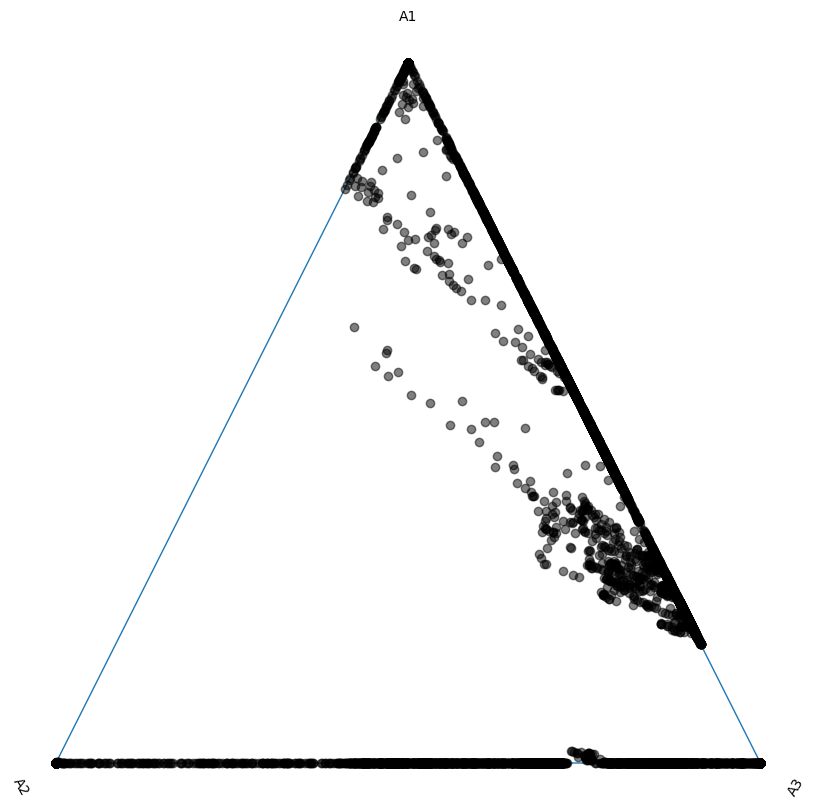

HERE - 0
HERE - 1
HERE - last


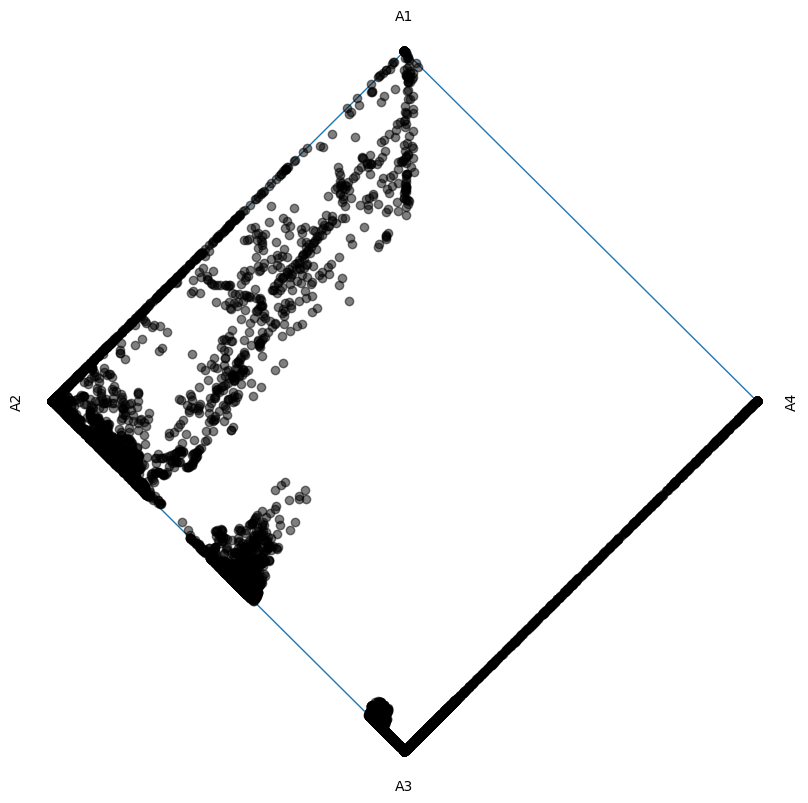

HERE - 0
HERE - 1
HERE - last


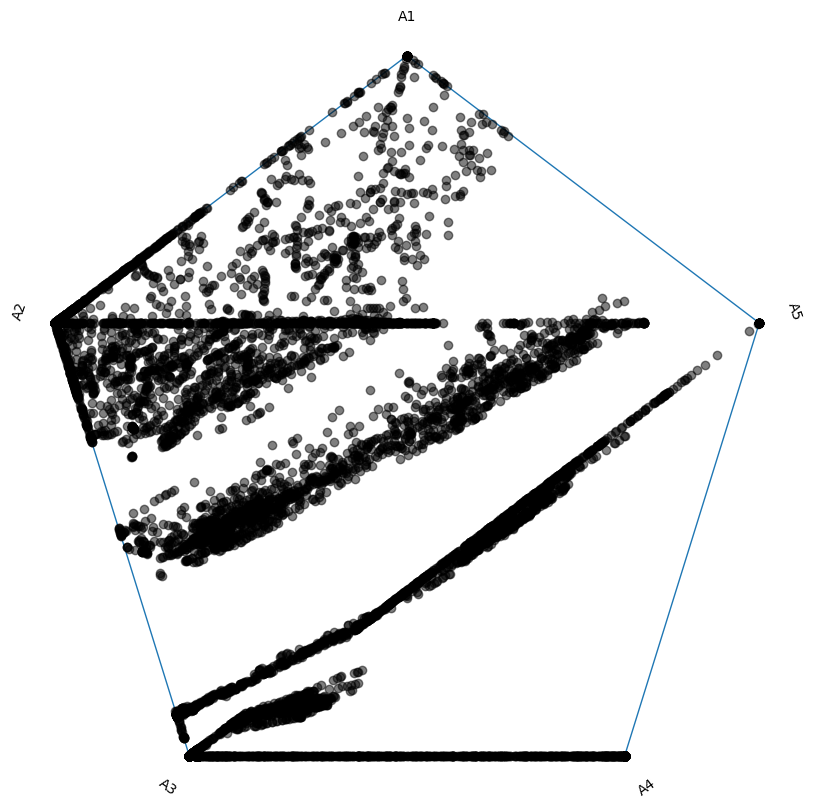

HERE - 0
HERE - 1
HERE - last


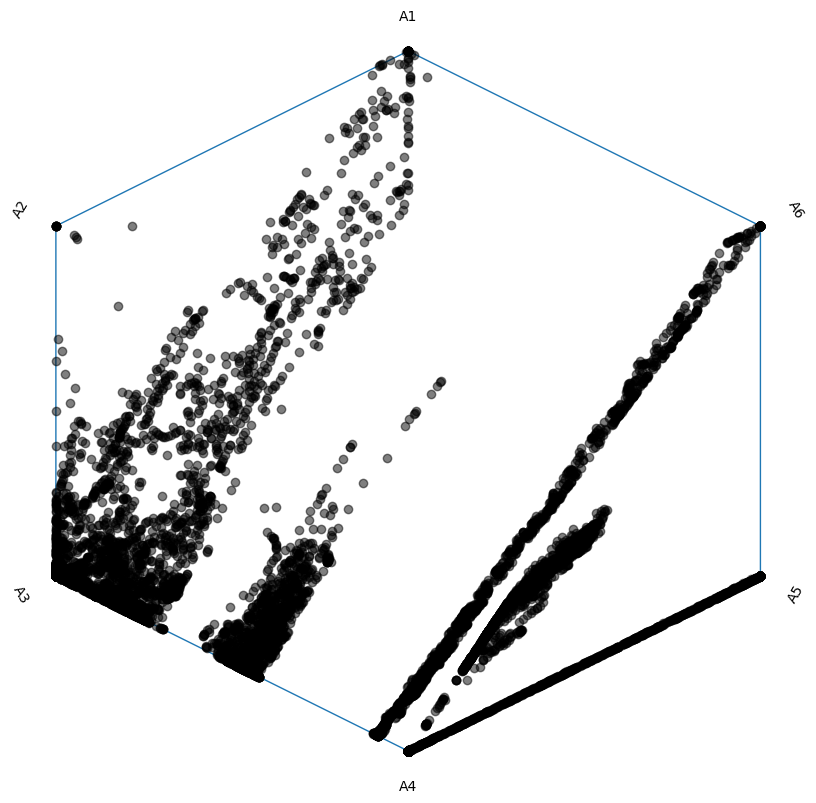

HERE - 0
HERE - 1
HERE - last


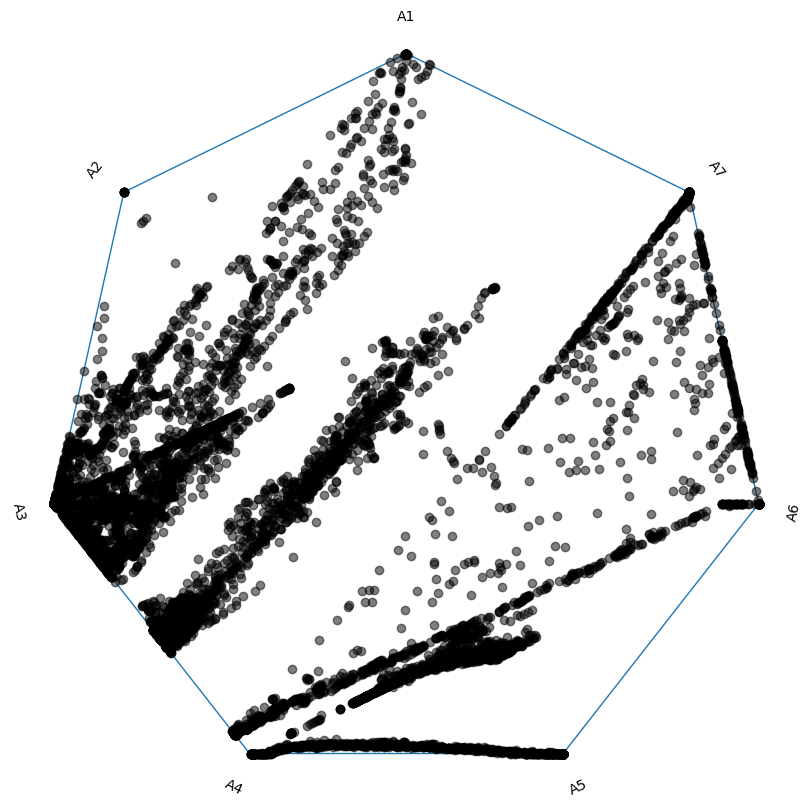

HERE - 0
HERE - 1
HERE - last


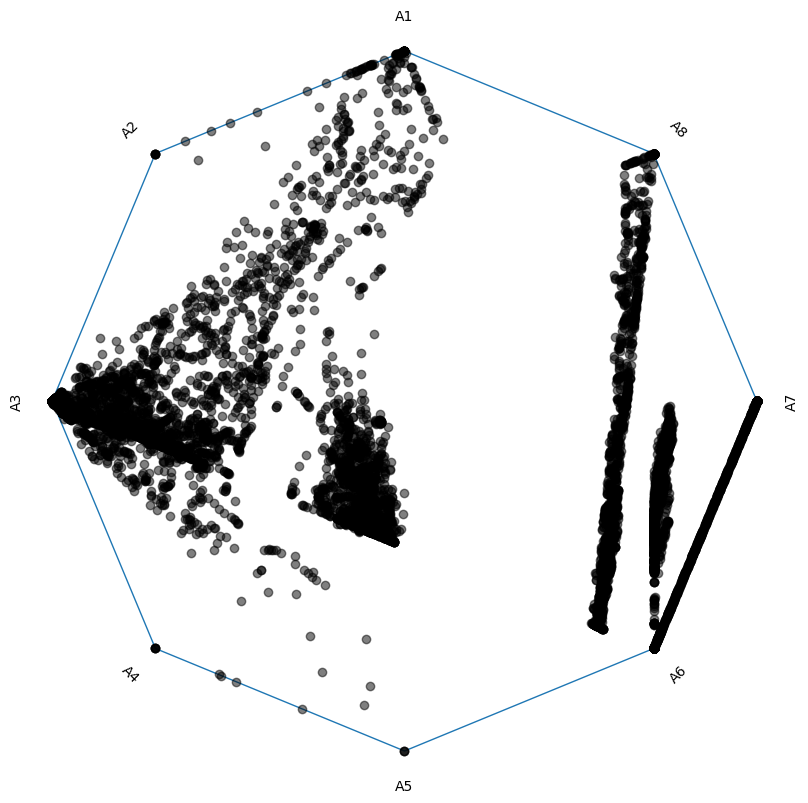

In [111]:
AA_list=[]
for i in range(3,9):
    AA = ArchetypalAnalysis(n_archetypes = i, 
                            tolerance = 0.001, 
                            max_iter = 200, 
                            random_state = 0, 
                            C = 0.0001, 
                            initialize = 'random',
                            redundancy_try = 30)
    AA.fit(X_scaled)
    AA.plot_simplex(AA.alfa)
    AA_list.append(AA)

HERE - 0
HERE - 1
HERE - last


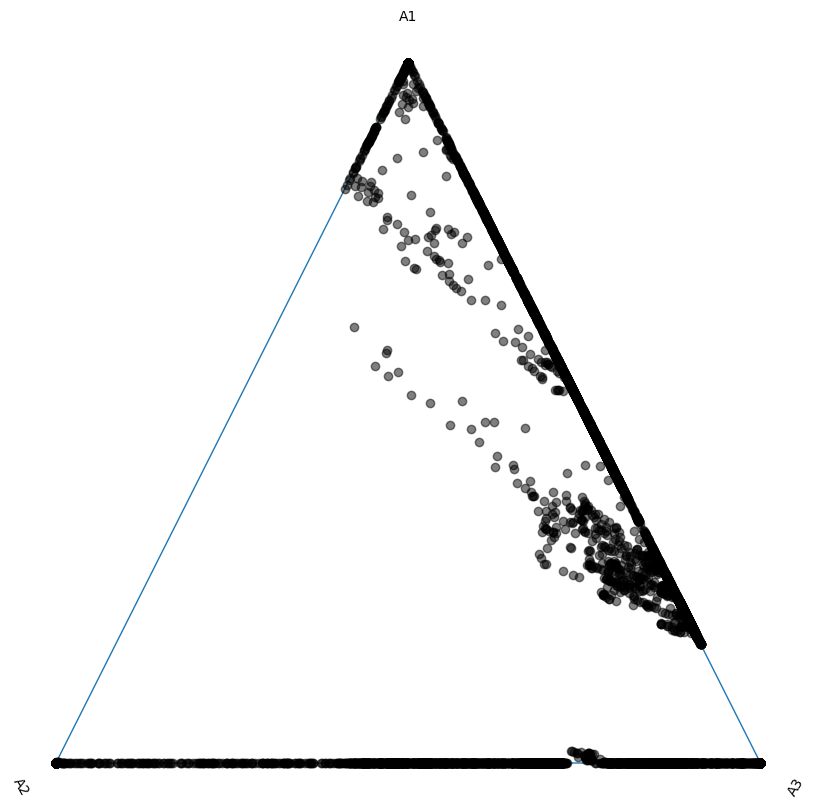

In [112]:
AA3 = ArchetypalAnalysis(n_archetypes = 3, 
                        tolerance = 0.001, 
                        max_iter = 200, 
                        random_state = 0, 
                        C = 0.0001, 
                        initialize = 'random',
                        redundancy_try = 30)
AA3.fit(X_scaled)
AA3.plot_simplex(AA3.alfa)

In [113]:
def plot_simplex(n_archetypes, alfa, color_vertex, plot_args={}, grid_on=True):
    vertex_colors = ['red', 'blue', 'green', 'yellow']
    labels = ('A'+str(i + 1) for i in range(n_archetypes))
    rotate_labels = True
    label_offset = 0.10
    data = alfa.T
    scaling = False
    sides = n_archetypes
    basis = np.array(
        [
            [
                np.cos(2*_*pi/sides + 90*pi/180),
                np.sin(2*_*pi/sides + 90*pi/180)
            ] 
            for _ in range(sides)
        ]
    )     

    # If data is Nxsides, newdata is Nx2.
    if scaling:
        # Scales data for you.
        newdata = np.dot((data.T / data.sum(-1)).T, basis)
    else:
        # Assumes data already sums to 1.
        newdata = np.dot(data, basis)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    for i, l in enumerate(labels):
        if i >= sides:
            break
        x = basis[i, 0]
        y = basis[i, 1]
        if rotate_labels:
            angle = 180*np.arctan(y/x)/pi + 90
            if angle > 90 and angle <= 270:
                angle = (angle + 180) % 360
        else:
            angle = 0
        ax.text(
            x*(1 + label_offset),
            y*(1 + label_offset),
            l,
            horizontalalignment='center',
            verticalalignment='center',
            rotation=angle
        )

    # Clear normal matplotlib axes graphics.
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_frame_on(False)

    # Plot border
    lst_ax_0 = []
    lst_ax_1 = []
    for _ in range(sides):
        lst_ax_0.append(basis[_, 0])
        lst_ax_1.append(basis[_, 1])

    lst_ax_0.append(basis[0, 0])
    lst_ax_1.append(basis[0, 1])

    ax.plot(lst_ax_0, lst_ax_1, linewidth=1, zorder=2) 
    
    # Plot vertices
    for i in range(len(color_vertex)):
        v = color_vertex[i]
        ax.scatter(basis[v, 0], basis[v, 1], color=vertex_colors[i], s=200, zorder=4)

    if len(plot_args) == 0:
        ax.scatter(newdata[:, 0], newdata[:, 1], color='black', zorder=3, alpha=0.5)
    else:
        if ('marker' in plot_args):   
            marker_vals = plot_args['marker'].values
            marker_unq = np.unique(marker_vals)                
            
            for marker in marker_unq:
                row_idx = np.where(marker_vals == marker)
                tmp_arg = {}
                for keys in plot_args:
                    if (keys!= 'marker'):
                        tmp_arg[keys] = plot_args[keys].values[row_idx]
                
                ax.scatter(newdata[row_idx,0],newdata[row_idx,1], **tmp_arg, marker =  marker, alpha=0.5, zorder=3)
        else:
            ax.scatter(newdata[:, 0], newdata[:, 1], **plot_args, marker='s', zorder=3, alpha=0.5)
            
    plt.show()

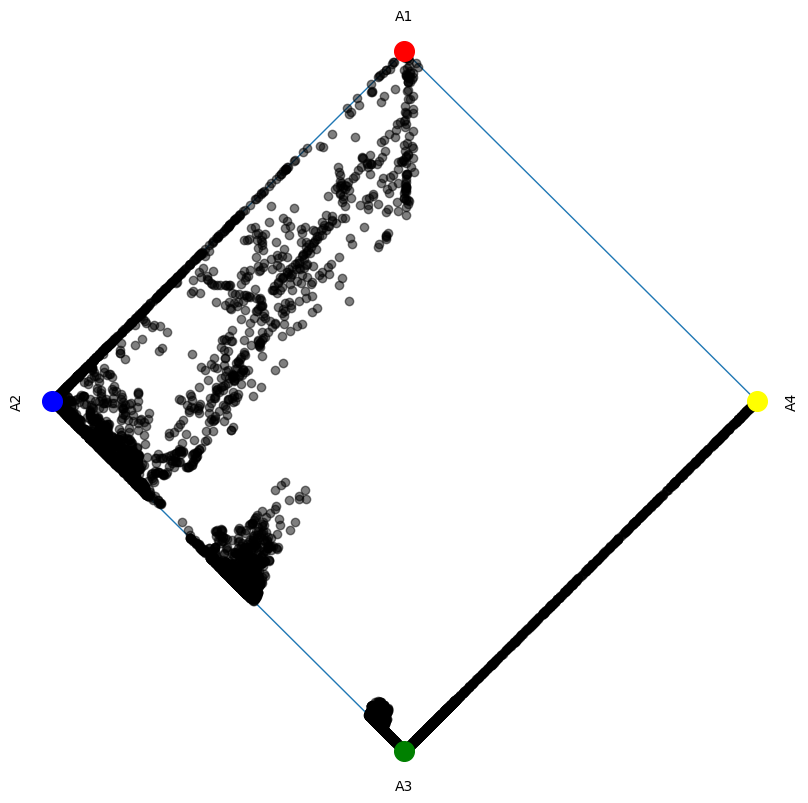

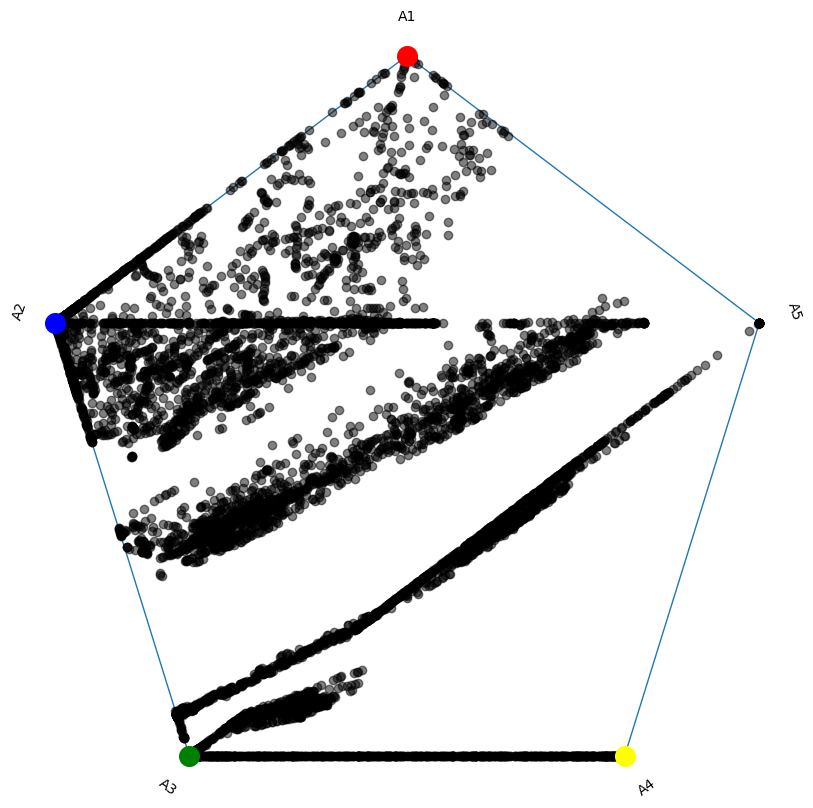

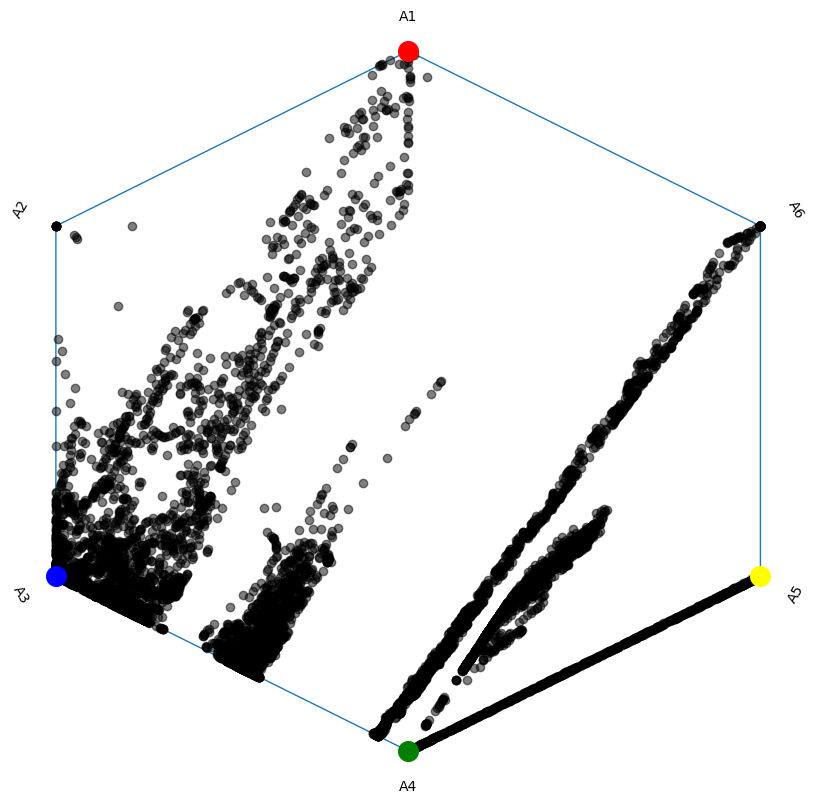

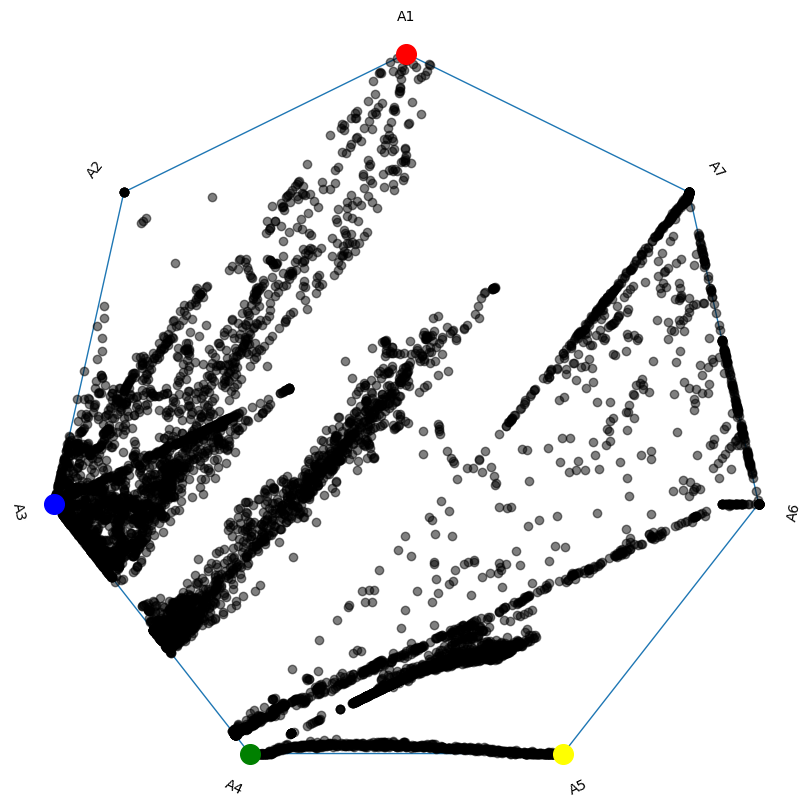

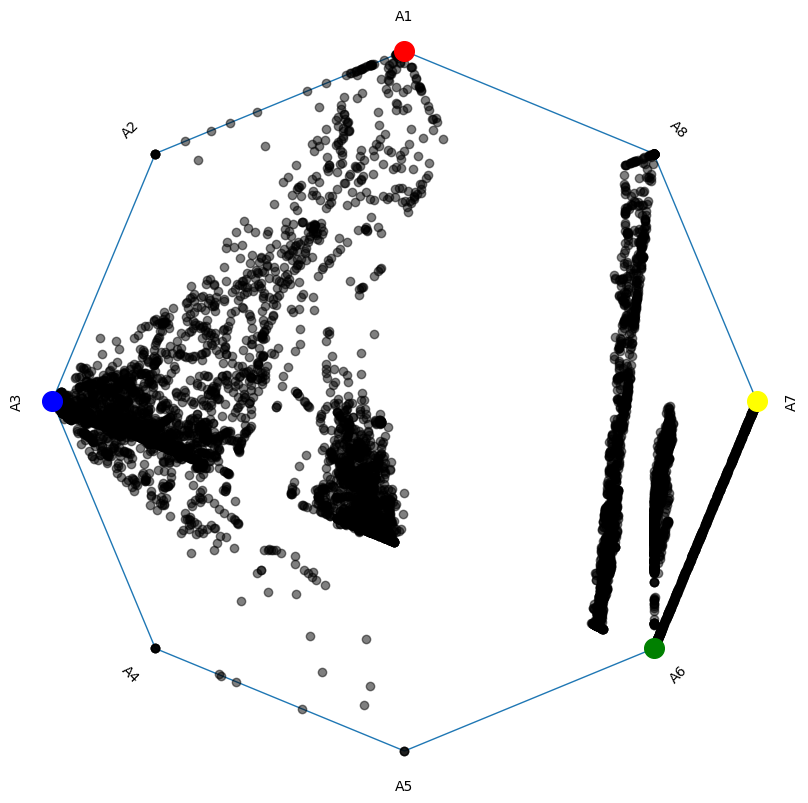

In [114]:
arr1 = AA_list[1].archetypes.T
color_indices = []
for AA in AA_list[1:]:
    arr2 = AA.archetypes.T
    similarities = cosine_similarity(arr1, arr2)
    sorted_indices = np.argsort(similarities, axis=None)[::-1]
    max_indices = np.unravel_index(sorted_indices, similarities.shape)
    sorted_indices = sorted(zip(max_indices[0][:4], max_indices[1][:4]), key=lambda x: x[0])
    sorted_second_indices = [idx2 for _, idx2 in sorted_indices]
    plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args={}, grid_on=True)

In [115]:
df

Location Level  cos_sza  \
filename                                                         
AmazonTwilight_L10_20180101_2215.txt     Amazon   L10 -0.03130   
AmazonTwilight_L10_20180101_2230.txt     Amazon   L10 -0.09118   
AmazonTwilight_L10_20180401_2130.txt     Amazon   L10  0.13430   
AmazonTwilight_L10_20180402_1015.txt     Amazon   L10  0.05223   
AmazonTwilight_L10_20180702_0945.txt     Amazon   L10 -0.08890   
...                                         ...   ...      ...   
Utqiagvik_L56_20181001_1215.txt       Utqiagvik   L56 -0.33000   
Utqiagvik_L56_20181001_1315.txt       Utqiagvik   L56 -0.28060   
Utqiagvik_L56_20181001_1500.txt       Utqiagvik   L56 -0.15880   
Utqiagvik_L56_20181001_2015.txt       Utqiagvik   L56  0.22520   
Utqiagvik_L56_20181001_2030.txt       Utqiagvik   L56  0.23550   

                                             Timestamp            C1  \
filename                                                               
AmazonTwilight_L10_20180101_2215.txt  2018/01/01 22:15  0.000000e+00   
AmazonTwilight_L10_20180101_2230.txt  2018/01/01 22:30  1.107667e-19   
AmazonTwilight_L10_20180401_2130.txt  2018/04/01 21:30  0.000000e+00   
AmazonTwilight_L10_20180402_1015.txt  2018/04/02 10:15  1.436701e-05   
AmazonTwilight_L10_20180702_0945.txt  2018/07/02 09:45  2.759965e-09   
...                                                ...           ...   
Utqiagvik_L56_20181001_1215.txt       2018/10/01 12:15  7.233056e-23   
Utqiagvik_L56_20181001_1315.txt       2018/10/01 13:15  7.237561e-23   
Utqiagvik_L56_20181001_1500.txt       2018/10/01 15:00  7.239111e-23   
Utqiagvik_L56_20181001_2015.txt       2018/10/01 20:15  7.209235e-23   
Utqiagvik_L56_20181001_2030.txt       2018/10/01 20:30  7.203199e-23   

                                                C2            C3  \
filename                                                           
AmazonTwilight_L10_20180101_2215.txt  1.200019e-09  2.552670e+00   
AmazonTwilight_L10_20180101_2230.txt  1.321647e-09  2.671705e+00   
AmazonTwilight_L10_20180401_2130.txt  9.898434e-08  3.806718e+00   
AmazonTwilight_L10_20180402_1015.txt  4.475333e-05  1.702778e+01   
AmazonTwilight_L10_20180702_0945.txt  2.622172e-08  2.930876e-02   
...                                            ...           ...   
Utqiagvik_L56_20181001_1215.txt       8.772422e-23  1.098368e-22   
Utqiagvik_L56_20181001_1315.txt       8.777887e-23  1.099052e-22   
Utqiagvik_L56_20181001_1500.txt       8.779766e-23  1.099288e-22   
Utqiagvik_L56_20181001_2015.txt       8.743531e-23  1.094751e-22   
Utqiagvik_L56_20181001_2030.txt       8.736211e-23  1.093834e-22   

                                                C4            C5   C6  ...  \
filename                                                               ...   
AmazonTwilight_L10_20180101_2215.txt  5.595636e+06  5.904771e+06  0.0  ...   
AmazonTwilight_L10_20180101_2230.txt  5.642886e+06  5.984096e+06  0.0  ...   
AmazonTwilight_L10_20180401_2130.txt  2.476942e+06  3.894954e+06  0.0  ...   
AmazonTwilight_L10_20180402_1015.txt  2.989333e+06  4.103141e+06  0.0  ...   
AmazonTwilight_L10_20180702_0945.txt  5.300508e+06  1.313549e+07  0.0  ...   
...                                            ...           ...  ...  ...   
Utqiagvik_L56_20181001_1215.txt       3.582395e+04  5.862016e+00  0.0  ...   
Utqiagvik_L56_20181001_1315.txt       3.584647e+04  5.868155e+00  0.0  ...   
Utqiagvik_L56_20181001_1500.txt       3.584991e+04  6.020692e+00  0.0  ...   
Utqiagvik_L56_20181001_2015.txt       3.567527e+04  6.879503e+00  0.0  ...   
Utqiagvik_L56_20181001_2030.txt       3.564453e+04  6.903848e+00  0.0  ...   

                                              C284           C285  \
filename                                                            
AmazonTwilight_L10_20180101_2215.txt  9.747906e+01       3.445056   
AmazonTwilight_L10_20180101_2230.txt  1.325201e+01       1.561496   
AmazonTwilight_L10_20180401_2130.txt  5.261566e+02      37.228411  

In [116]:
#all code together
'''
lst_feat = ['C'+str(i) for i in range(1,len(df.columns)+1)]

sc = StandardScaler()
X = df[lst_feat].values
X_scaled = sc.fit_transform(X)

AA_list=[]
for i in range(3,9):
    AA = ArchetypalAnalysis(n_archetypes = i, 
                            tolerance = 0.001, 
                            max_iter = 200, 
                            random_state = 0, 
                            C = 0.0001, 
                            initialize = 'random',
                            redundancy_try = 30)
    AA.fit(X_scaled)
    AA.plot_simplex(AA.alfa)
    AA_list.append(AA)
    
arr1 = AA_list[1].archetypes.T
color_indices = []
for AA in AA_list[1:]:
    arr2 = AA.archetypes.T
    similarities = cosine_similarity(arr1, arr2)
    sorted_indices = np.argsort(similarities, axis=None)[::-1]
    max_indices = np.unravel_index(sorted_indices, similarities.shape)
    sorted_indices = sorted(zip(max_indices[0][:4], max_indices[1][:4]), key=lambda x: x[0])
    sorted_second_indices = [idx2 for _, idx2 in sorted_indices]
    plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args={}, grid_on=True)
'''

"\nlst_feat = ['C'+str(i) for i in range(1,len(df.columns)+1)]\n\nsc = StandardScaler()\nX = df[lst_feat].values\nX_scaled = sc.fit_transform(X)\n\nAA_list=[]\nfor i in range(3,9):\n    AA = ArchetypalAnalysis(n_archetypes = i, \n                            tolerance = 0.001, \n                            max_iter = 200, \n                            random_state = 0, \n                            C = 0.0001, \n                            initialize = 'random',\n                            redundancy_try = 30)\n    AA.fit(X_scaled)\n    AA.plot_simplex(AA.alfa)\n    AA_list.append(AA)\n    \narr1 = AA_list[1].archetypes.T\ncolor_indices = []\nfor AA in AA_list[1:]:\n    arr2 = AA.archetypes.T\n    similarities = cosine_similarity(arr1, arr2)\n    sorted_indices = np.argsort(similarities, axis=None)[::-1]\n    max_indices = np.unravel_index(sorted_indices, similarities.shape)\n    sorted_indices = sorted(zip(max_indices[0][:4], max_indices[1][:4]), key=lambda x: x[0])\n    sorted_second

### Analysis on L1 Data

In [117]:
L1_data = df[df['Level'] == 'L1']
L1_data.head()

Location Level   cos_sza  \
filename                                                       
AmazonTwilight_L1_20180101_2145.txt   Amazon    L1  0.088880   
AmazonTwilight_L1_20180102_0930.txt   Amazon    L1 -0.106800   
AmazonTwilight_L1_20180102_1000.txt   Amazon    L1  0.013090   
AmazonTwilight_L1_20180401_2145.txt   Amazon    L1  0.069550   
AmazonTwilight_L1_20180401_2200.txt   Amazon    L1  0.004448   

                                            Timestamp            C1  \
filename                                                              
AmazonTwilight_L1_20180101_2145.txt  2018/01/01 21:45  3.052816e-20   
AmazonTwilight_L1_20180102_0930.txt  2018/01/02 09:30  6.995158e-08   
AmazonTwilight_L1_20180102_1000.txt  2018/01/02 10:00  1.070683e-07   
AmazonTwilight_L1_20180401_2145.txt  2018/04/01 21:45  3.077165e-20   
AmazonTwilight_L1_20180401_2200.txt  2018/04/01 22:00  3.079688e-20   

                                               C2        C3            C4  \
filename                                                                    
AmazonTwilight_L1_20180101_2145.txt  2.020170e-09  0.994475  1.053929e+07   
AmazonTwilight_L1_20180102_0930.txt  5.016983e-07  4.090740  1.030287e+07   
AmazonTwilight_L1_20180102_1000.txt  6.821389e-07  4.261047  1.031528e+07   
AmazonTwilight_L1_20180401_2145.txt  1.364043e-06  4.497337  7.980339e+06   
AmazonTwilight_L1_20180401_2200.txt  1.342583e-06  4.496913  7.922160e+06   

                                               C5   C6  ...          C284  \
filename                                                ...                 
AmazonTwilight_L1_20180101_2145.txt  1.009544e+07  0.0  ...  4.021695e+02   
AmazonTwilight_L1_20180102_0930.txt  1.047625e+07  0.0  ...  2.833716e-07   
AmazonTwilight_L1_20180102_1000.txt  1.054448e+07  0.0  ...  2.363660e+00   
AmazonTwilight_L1_20180401_2145.txt  1.060702e+07  0.0  ...  1.337019e+02   
AmazonTwilight_L1_20180401_2200.txt  1.053446e+07  0.0  ...  7.196470e+01   

                                         C285          C286        C287  \
filename                                                                  
AmazonTwilight_L1_20180101_2145.txt  0.962945  3.272561e+08  614.509313   
AmazonTwilight_L1_20180102_0930.txt  1.099693  2.510648e+06   25.233783   
AmazonTwilight_L1_20180102_1000.txt  1.512381  2.309595e+06  464.469923   
AmazonTwilight_L1_20180401_2145.txt  1.841164  2.169260e+07  651.865917   
AmazonTwilight_L1_20180401_2200.txt  1.601029  2.410603e+07  513.992855   

                                             C288          C289          C290  \
filename                                                                        
AmazonTwilight_L1_20180101_2145.txt  1.175729e+13  1.849342e+19  4.962052e+18   
AmazonTwilight_L1_20180102_0930.txt  1.194404e+13  1.874597e+19  5.029816e+18   
AmazonTwilight_L1_20180102_1000.txt  1.195719e+13  1.876564e+19  5.035095e+18   
AmazonTwilight_L1_20180401_2145.txt  1.186931e+13  1.864092e+19  5.001629e+18   
AmazonTwilight_L1_20180401_2200.txt  1.187794e+13  1.865620e+19  5.005729e+18   

                                         C291  Twilight    Region  
filename                                                           
AmazonTwilight_L1_20180101_2145.txt  0.236852      True  Biogenic  
AmazonTwilight_L1_20180102_0930.txt  0.240086      True  Biogenic  
AmazonTwilight_L1_20180102_1000.txt  0.240338      True  Biogenic  
AmazonTwilight_L1_20180401_2145.txt  0.238741      True  Biogenic  
AmazonTwilight_L1_20180401_2200.txt  0.238937      True  Biogenic  

[5 rows x 297 columns]

In [118]:
df_args = L1_data[['Region']].copy()
df_args['color'] = df_args['Region'].map(region_color)
plot_args = {'color': df_args['color']}

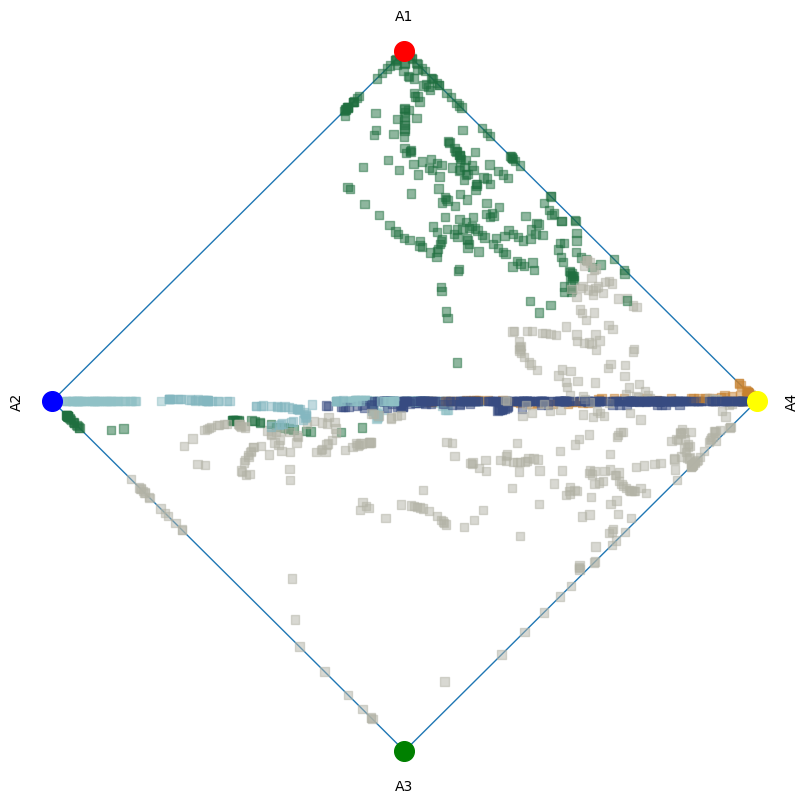

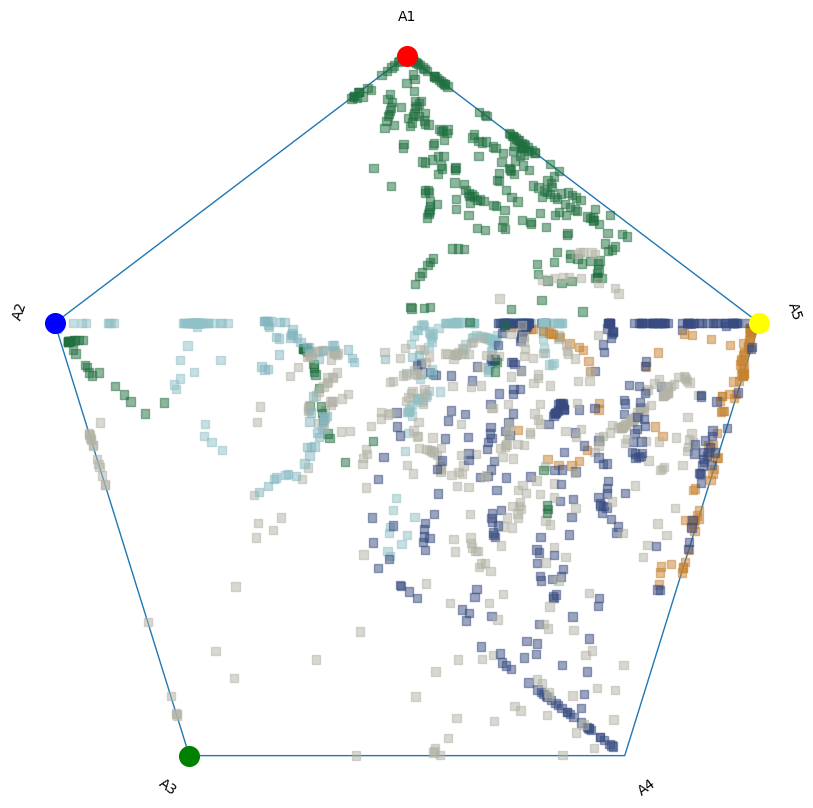

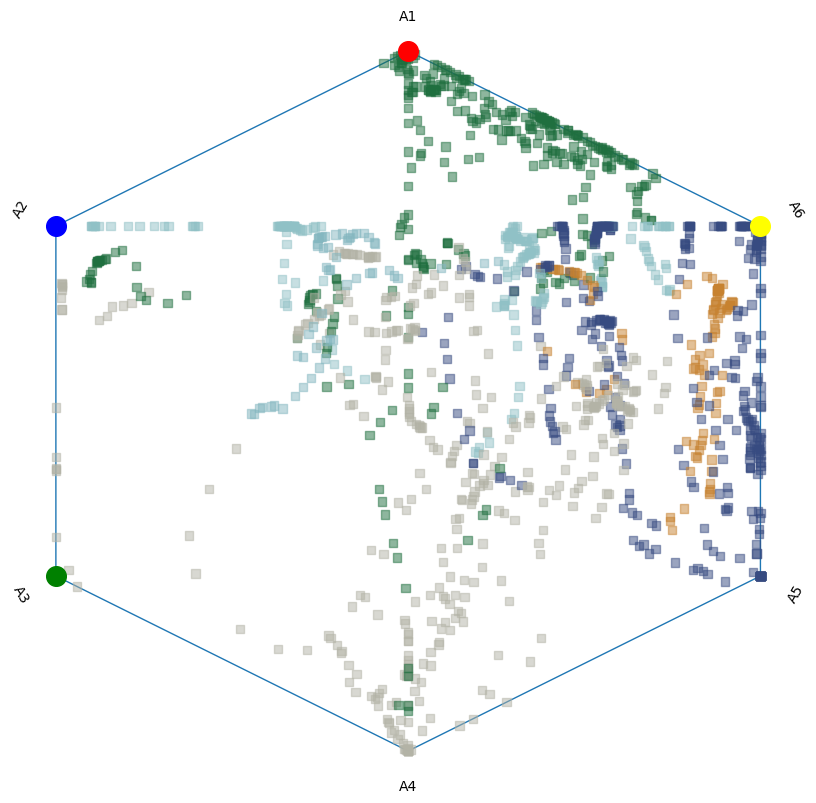

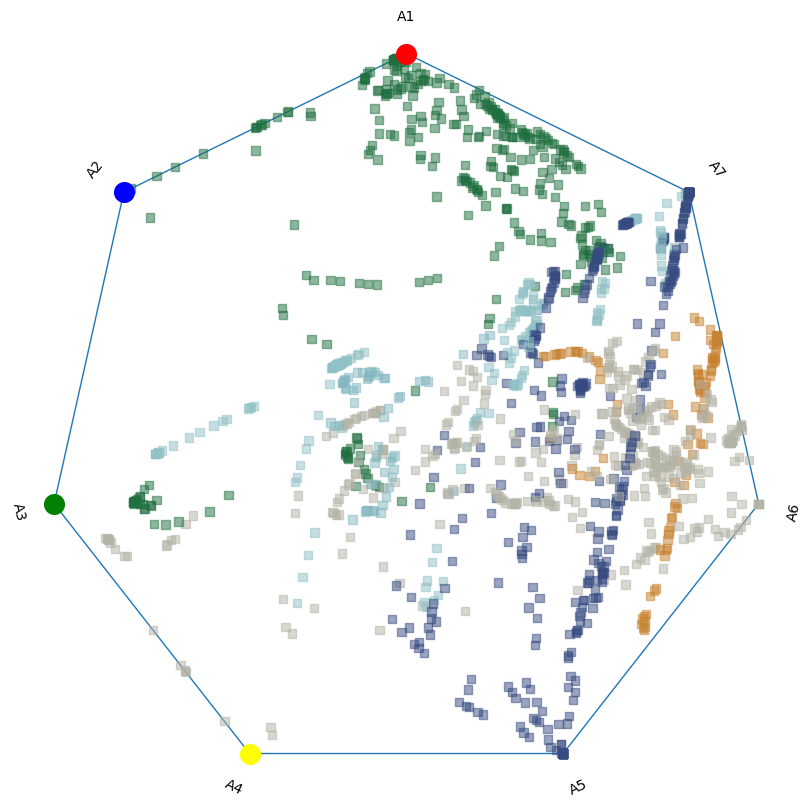

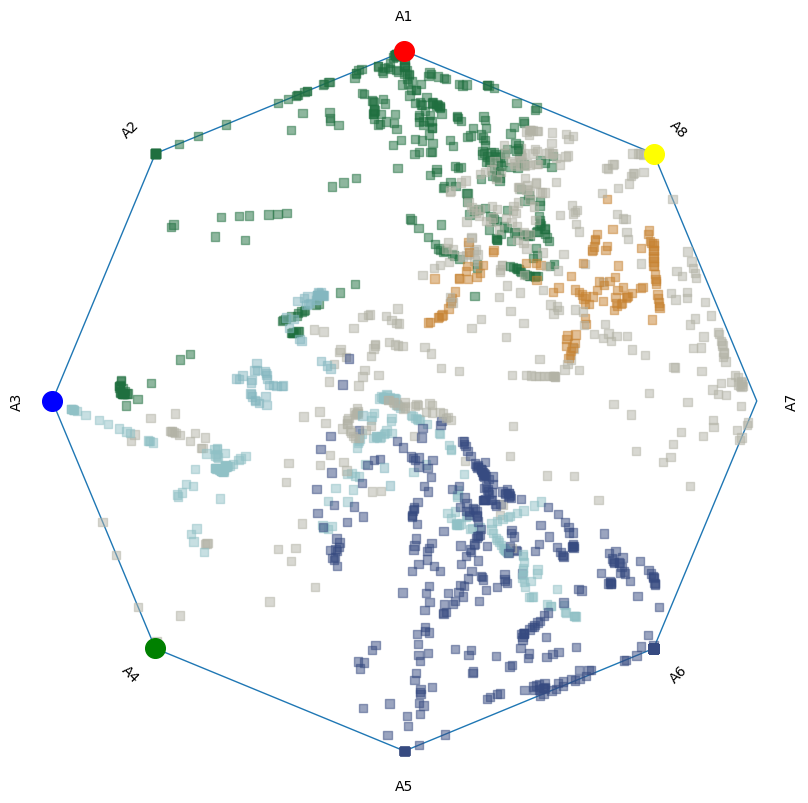

In [119]:
lst_feat = ['C'+str(i) for i in range(1,len(L1_data.columns)+1-6)]

sc = StandardScaler()
X = L1_data[lst_feat].values
X_scaled = sc.fit_transform(X)

AA_list=[]
for i in range(3,9):
    AA = ArchetypalAnalysis(n_archetypes = i, 
                            tolerance = 0.001, 
                            max_iter = 200, 
                            random_state = 0, 
                            C = 0.0001, 
                            initialize = 'random',
                            redundancy_try = 30)
    AA.fit(X_scaled)
#     AA.plot_simplex(AA.alfa)
    AA_list.append(AA)
    
arr1 = AA_list[1].archetypes.T
color_indices = []
for AA in AA_list[1:]:
    arr2 = AA.archetypes.T
    similarities = cosine_similarity(arr1, arr2)
    sorted_indices = np.argsort(similarities, axis=None)[::-1]
    max_indices = np.unravel_index(sorted_indices, similarities.shape)
    sorted_indices = sorted(zip(max_indices[0][:4], max_indices[1][:4]), key=lambda x: x[0])
    sorted_second_indices = [idx2 for _, idx2 in sorted_indices]
    plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args=plot_args, grid_on=True)

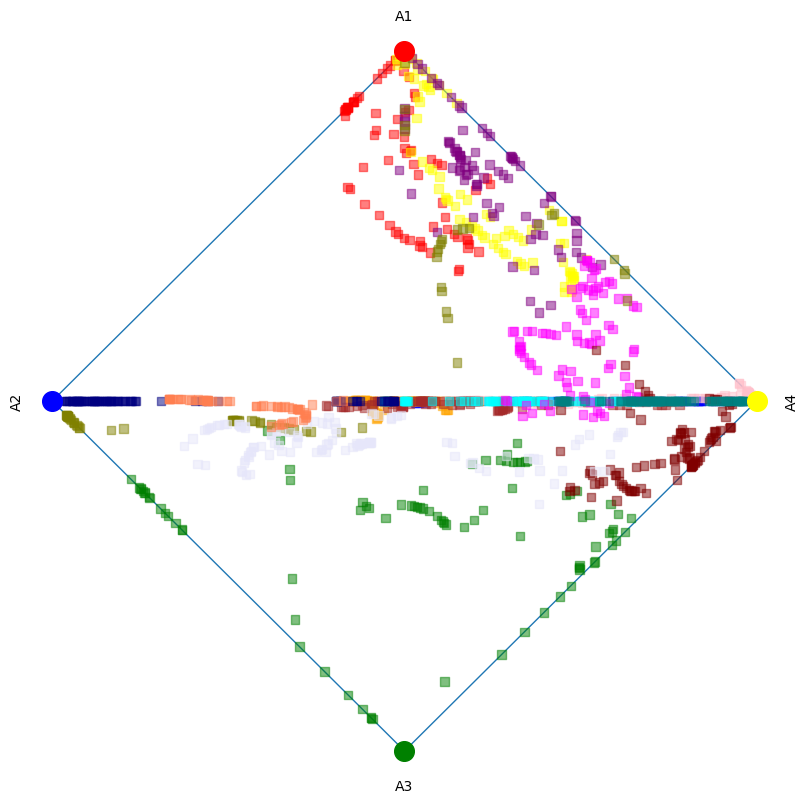

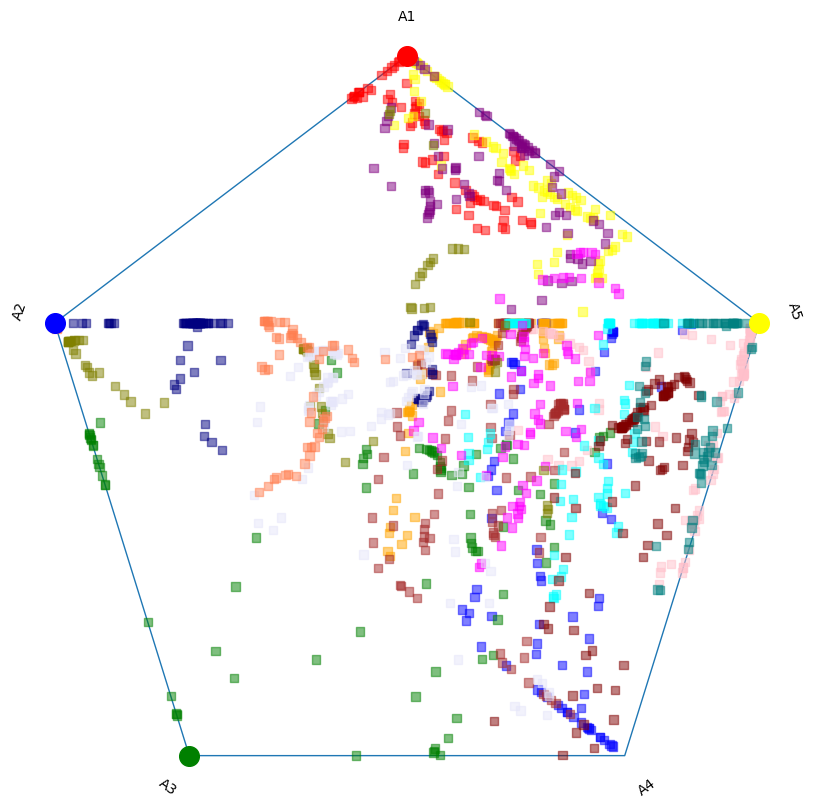

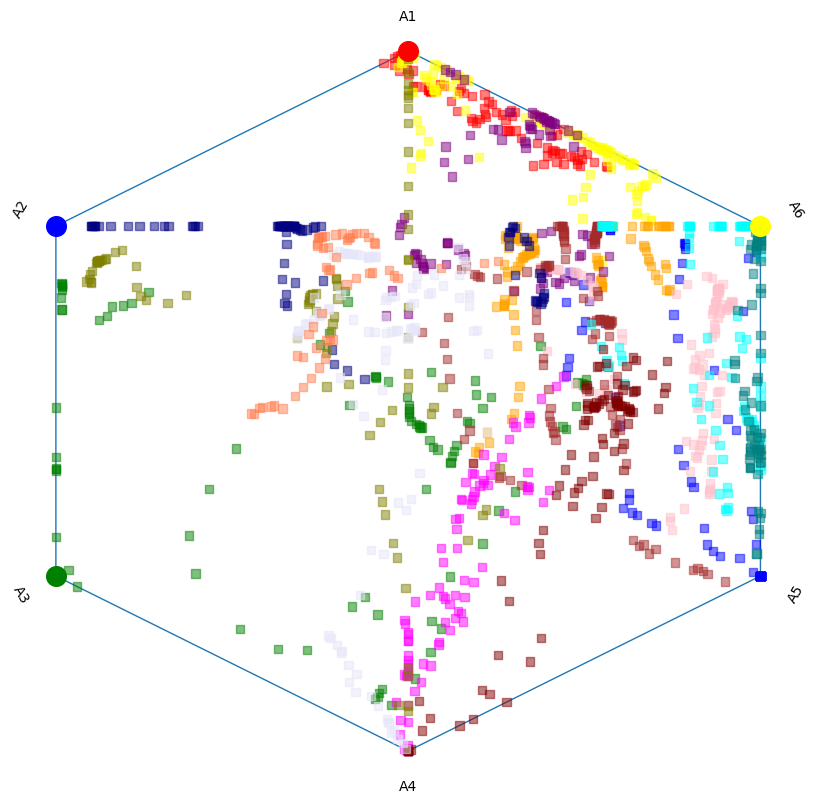

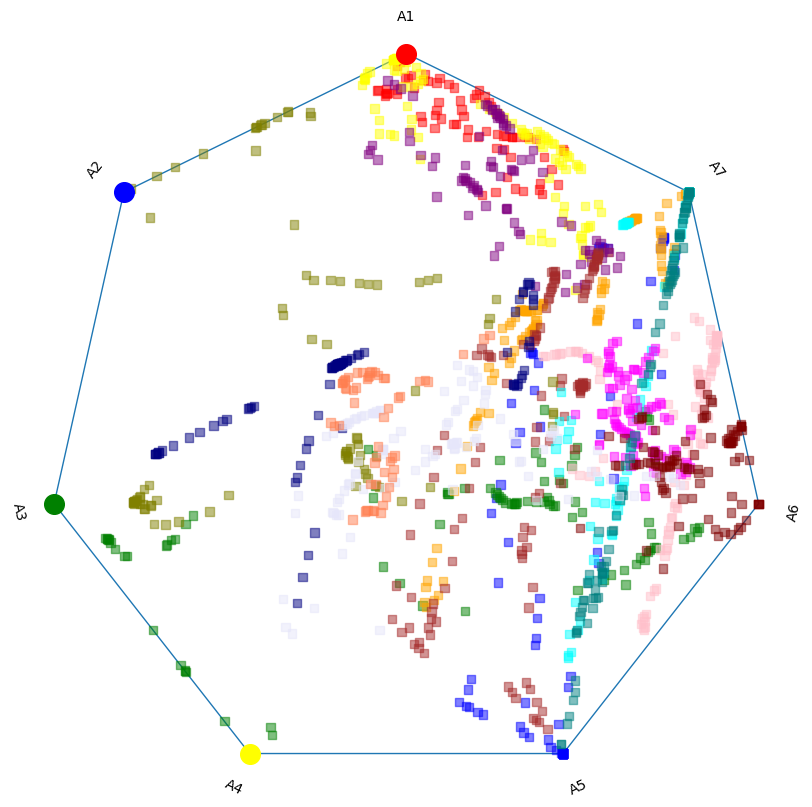

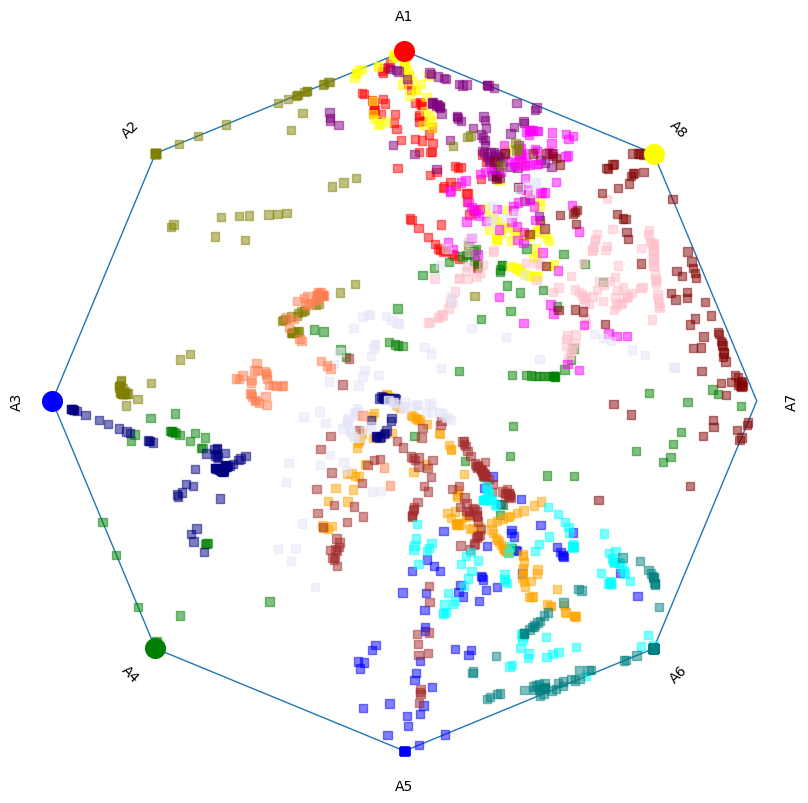

In [120]:
colors = ['Red', 'Blue', 'Green', 'Yellow', 'Orange', 'Purple', 'Pink', 'Brown', 'Cyan', 'Magenta', 'Maroon', 'Navy', 'Olive', 'Teal', 'Lavender', 'Coral']

df_args = L1_data[['Location']].copy()
df_args['Location'] = [i.replace('Twilight','') for i in df_args['Location']]

df_args['color'] = colors[0]
uniq_locations = df_args['Location'].unique()
for i in range(len(uniq_locations)):
    df_args['color'][df_args['Location']==uniq_locations[i]] = colors[i]

plot_args = {'color': df_args['color']}


arr1 = AA_list[1].archetypes.T
color_indices = []
for AA in AA_list[1:]:
    arr2 = AA.archetypes.T
    similarities = cosine_similarity(arr1, arr2)
    sorted_indices = np.argsort(similarities, axis=None)[::-1]
    max_indices = np.unravel_index(sorted_indices, similarities.shape)
    sorted_indices = sorted(zip(max_indices[0][:4], max_indices[1][:4]), key=lambda x: x[0])
    sorted_second_indices = [idx2 for _, idx2 in sorted_indices]
    plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args=plot_args, grid_on=True)

### Analysis on L1, Los Angeles Data

In [121]:
L1_data = df[df['Level'] == 'L1']
L1_LA_data = L1_data[L1_data['Location'] == 'LosAngeles']
L1_LA_data.head()

Location Level   cos_sza  \
filename                                                              
LosAngelesTwilight_L1_20180102_0045.txt  LosAngeles    L1 -0.026280   
LosAngelesTwilight_L1_20180102_0100.txt  LosAngeles    L1 -0.074680   
LosAngelesTwilight_L1_20180102_1445.txt  LosAngeles    L1 -0.022760   
LosAngelesTwilight_L1_20180102_1500.txt  LosAngeles    L1  0.024730   
LosAngelesTwilight_L1_20180402_0200.txt  LosAngeles    L1 -0.009294   

                                                Timestamp            C1  \
filename                                                                  
LosAngelesTwilight_L1_20180102_0045.txt  2018/01/02 00:45  5.253113e+05   
LosAngelesTwilight_L1_20180102_0100.txt  2018/01/02 01:00  6.884976e+05   
LosAngelesTwilight_L1_20180102_1445.txt  2018/01/02 14:45  5.008941e+06   
LosAngelesTwilight_L1_20180102_1500.txt  2018/01/02 15:00  4.791965e+06   
LosAngelesTwilight_L1_20180402_0200.txt  2018/04/02 02:00  3.448060e+05   

                                                   C2            C3  \
filename                                                              
LosAngelesTwilight_L1_20180102_0045.txt  8.261570e+05  3.268380e+06   
LosAngelesTwilight_L1_20180102_0100.txt  9.892873e+05  3.792292e+06   
LosAngelesTwilight_L1_20180102_1445.txt  4.619859e+06  1.404578e+07   
LosAngelesTwilight_L1_20180102_1500.txt  4.520203e+06  1.379913e+07   
LosAngelesTwilight_L1_20180402_0200.txt  5.404303e+05  2.260019e+06   

                                                   C4            C5   C6  ...  \
filename                                                                  ...   
LosAngelesTwilight_L1_20180102_0045.txt  1.813045e+07  1.892729e+07  0.0  ...   
LosAngelesTwilight_L1_20180102_0100.txt  1.810913e+07  1.908535e+07  0.0  ...   
LosAngelesTwilight_L1_20180102_1445.txt  1.793307e+07  1.764092e+07  0.0  ...   
LosAngelesTwilight_L1_20180102_1500.txt  1.794980e+07  1.761058e+07  0.0  ...   
LosAngelesTwilight_L1_20180402_0200.txt  1.694759e+07  1.692981e+08  0.0  ...   

                                               C284       C285          C286  \
filename                                                                       
LosAngelesTwilight_L1_20180102_0045.txt  572.931156   6.987265  1.442942e+10   
LosAngelesTwilight_L1_20180102_0100.txt  151.893804   2.363384  1.522128e+10   
LosAngelesTwilight_L1_20180102_1445.txt   25.266221   0.233292  1.773111e+10   
LosAngelesTwilight_L1_20180102_1500.txt  302.087809   1.477656  1.785566e+10   
LosAngelesTwilight_L1_20180402_0200.txt  598.054346  15.478041  7.508068e+09   

                                               C287          C288  \
filename                                                            
LosAngelesTwilight_L1_20180102_0045.txt  851.261091  1.133577e+13   
LosAngelesTwilight_L1_20180102_0100.txt  256.913469  1.134113e+13   
LosAngelesTwilight_L1_20180102_1445.txt   68.854162  1.158937e+13   
LosAngelesTwilight_L1_20180102_1500.txt  732.682667  1.159364e+13   
LosAngelesTwilight_L1_20180402_0200.txt  850.992770  1.112837e+13   

                                                 C289          C290      C291  \
filename                                                                        
LosAngelesTwilight_L1_20180102_0045.txt  1.766335e+19  4.739336e+18  0.226221   
LosAngelesTwilight_L1_20180102_0100.txt  1.767176e+19  4.741591e+18  0.226328   
LosAngelesTwilight_L1_20180102_1445.txt  1.805738e+19  4.845059e+18  0.231267   
LosAngelesTwilight_L1_20180102_1500.txt  1.806401e+19  4.846839e+18  0.231352   
LosAngelesTwilight_L1_20180402_0200.txt  1.738513e+19  4.664685e+18  0.222658   

                                         Twilight  Region  
filename                                                   
LosAngelesTwilight_L1_20180102_0045.txt      True   Urban  
LosAngelesTwilight_L1_20180102_0100.txt      True   Urban  
LosAngelesTwilight_L1_20180102_1445.txt      True   Urban  
LosAngelesTwilight_L1_20180102_1500.txt 

In [122]:
colors = ['Red', 'Blue', 'Green', 'Yellow', 'Orange', 'Purple', 'Pink', 'Brown', 'Cyan', 'Magenta', 'Maroon', 'Navy']
month_color = {i+1:colors[i] for i in range(12)}

df_args = L1_LA_data[['Timestamp']].copy()
df_args['Timestamp'] = pd.to_datetime(df_args['Timestamp'], format='%Y/%m/%d %H:%M')
df_args['Month'] = df_args['Timestamp'].dt.month

df_args['color'] = df_args['Month'].map(month_color)
plot_args = {'color': df_args['color']}

HERE - 0
HERE - 1
HERE - last


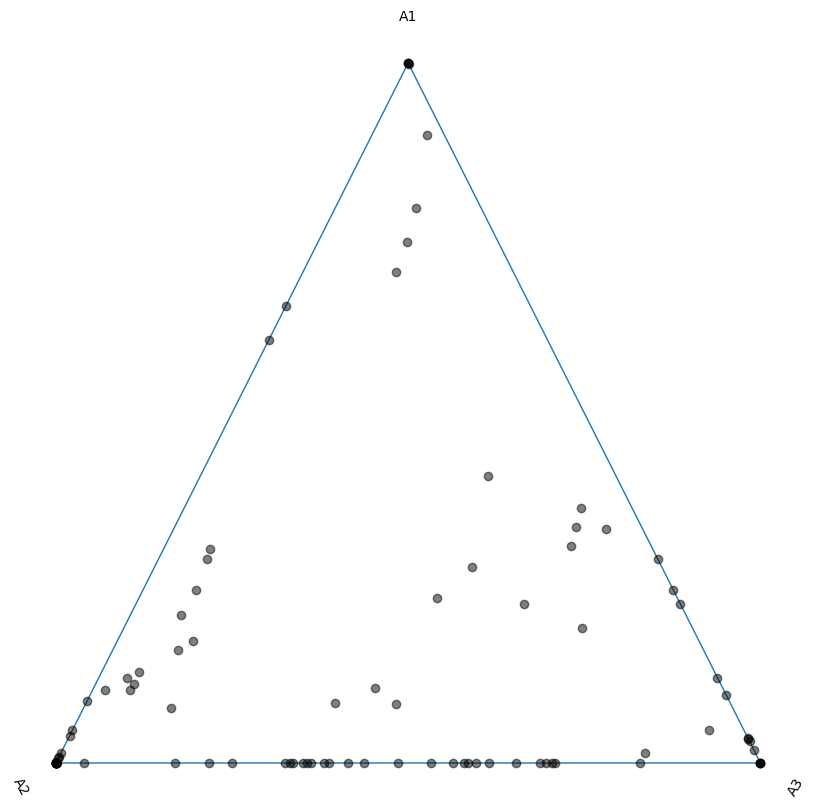

HERE - 0
HERE - 1
HERE - last


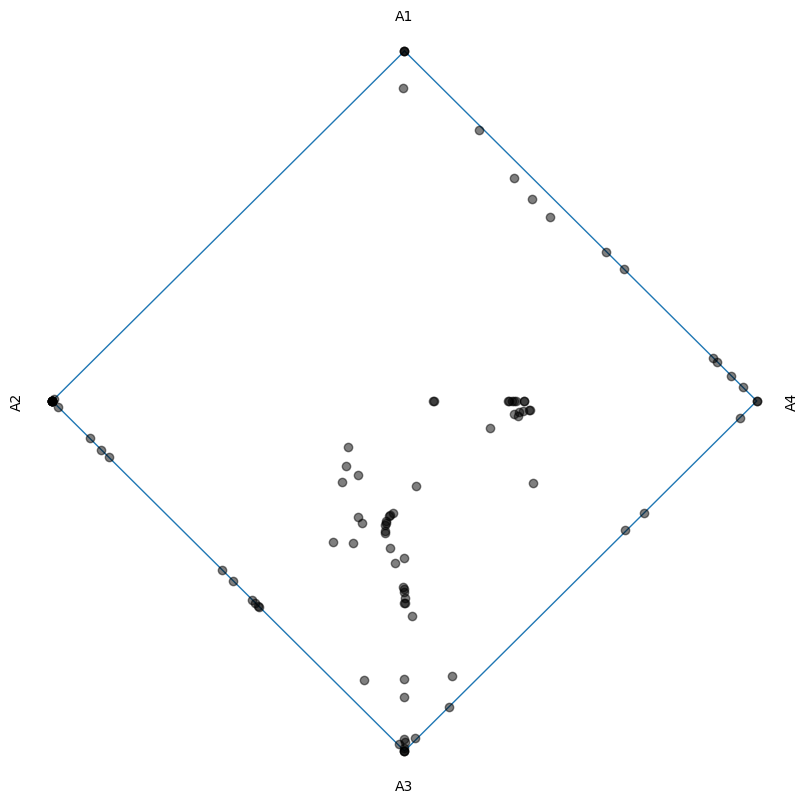

HERE - 0
HERE - 1
HERE - last


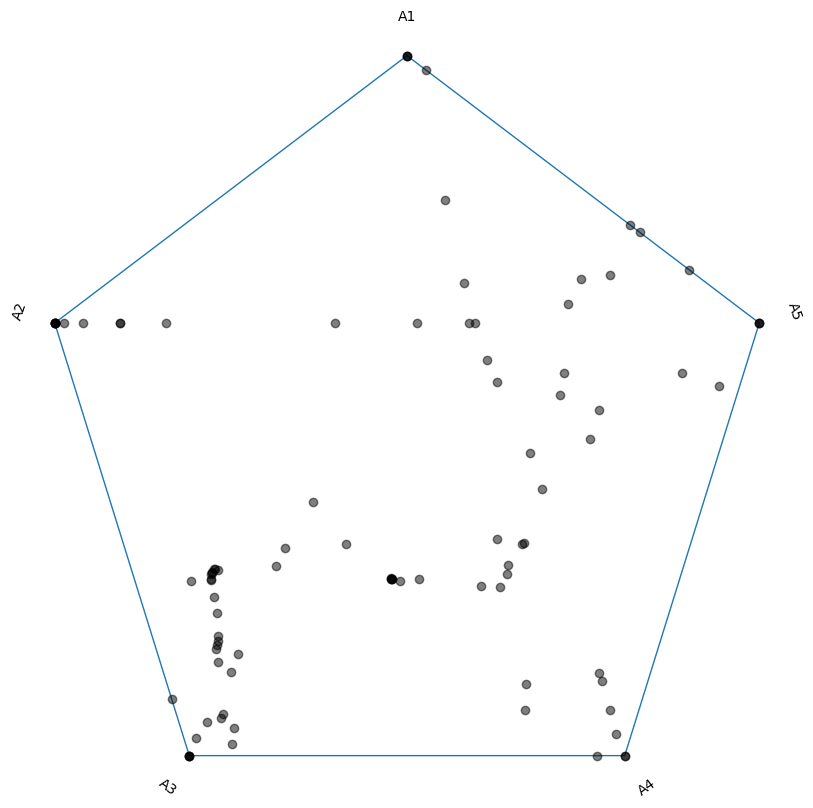

HERE - 0
HERE - 1
HERE - last


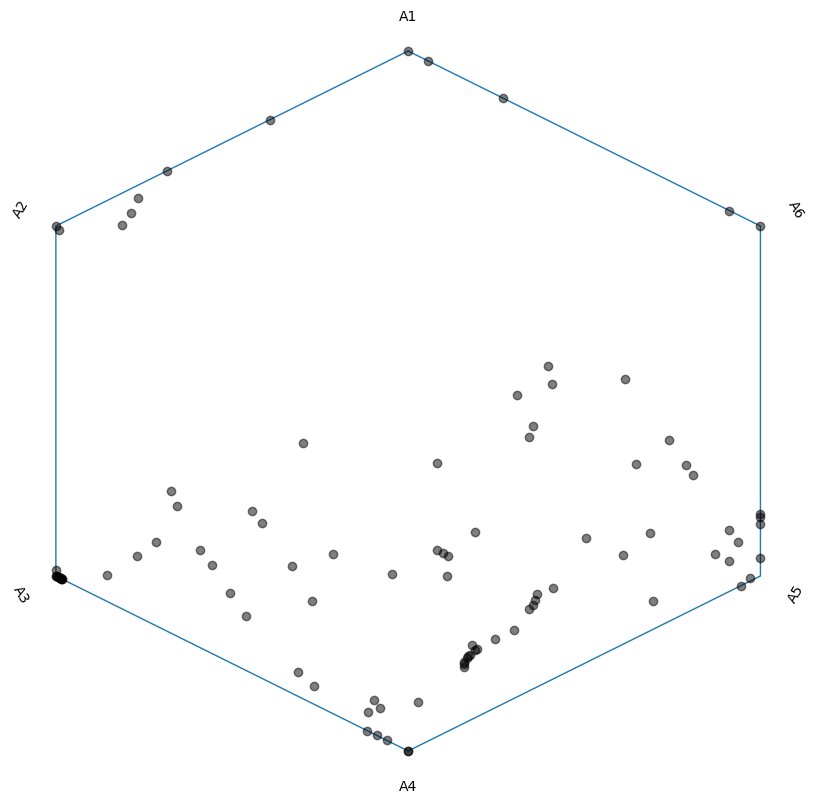

HERE - 0
HERE - 1
HERE - last


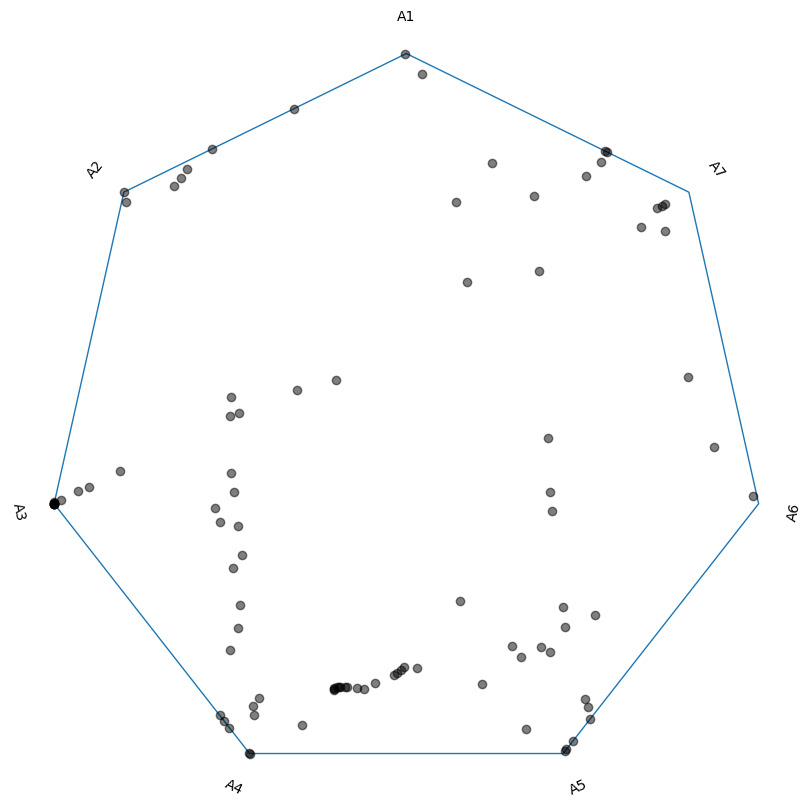

HERE - 0
HERE - 1
HERE - last


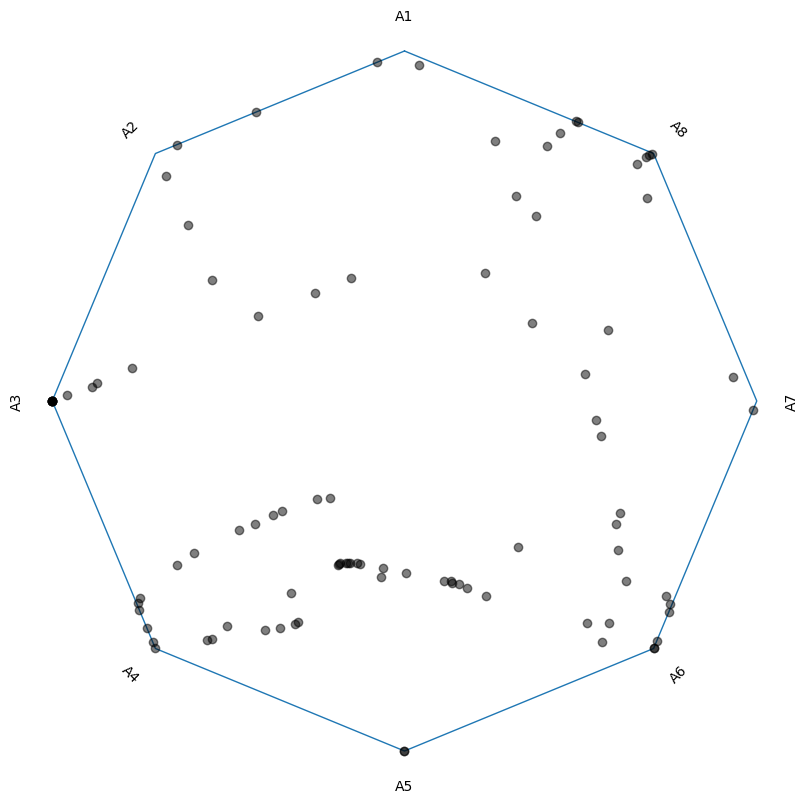

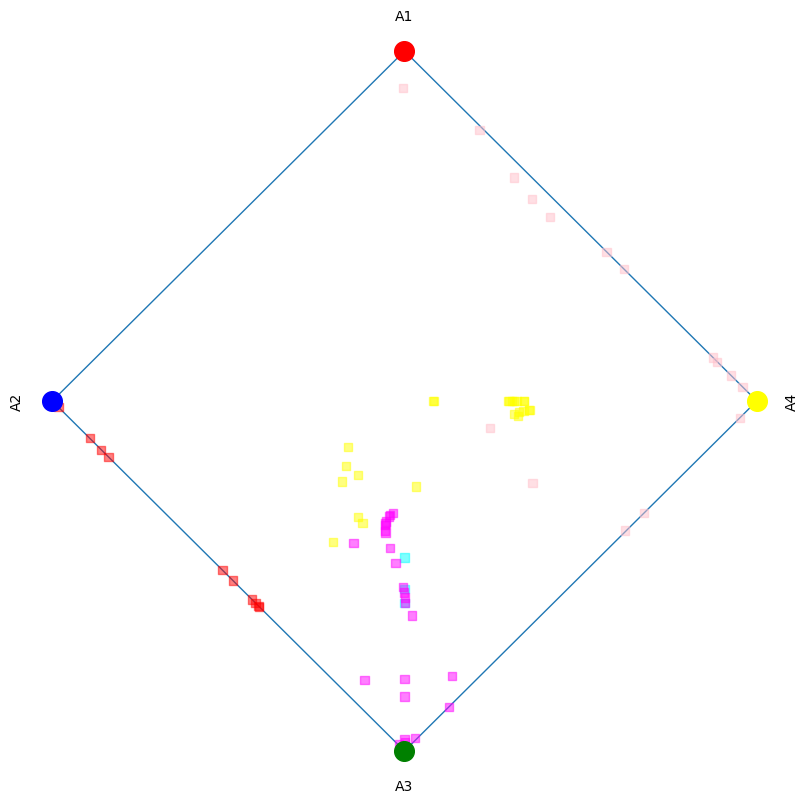

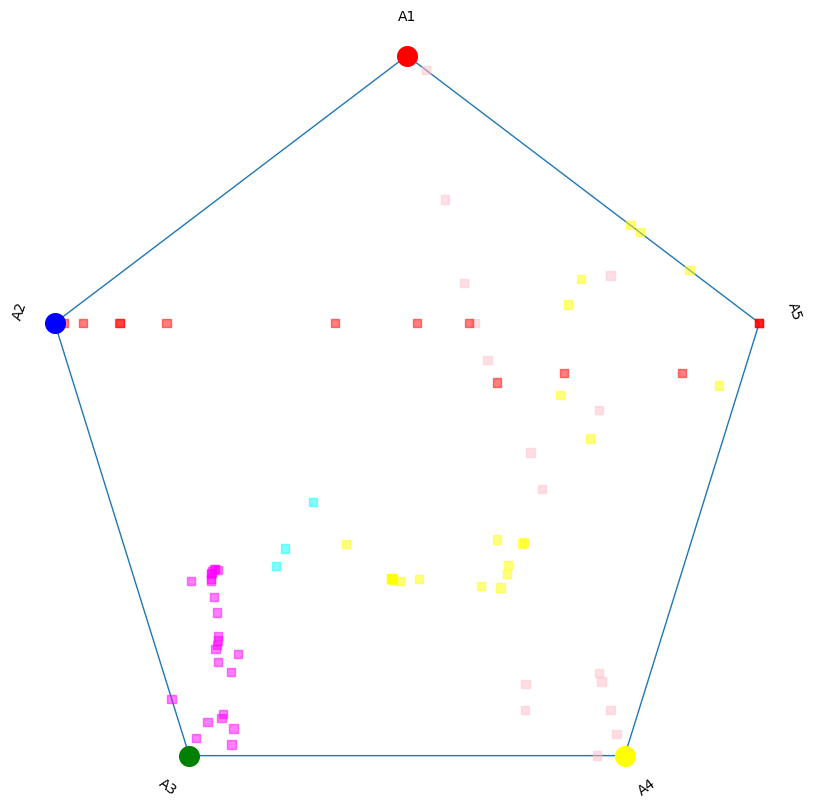

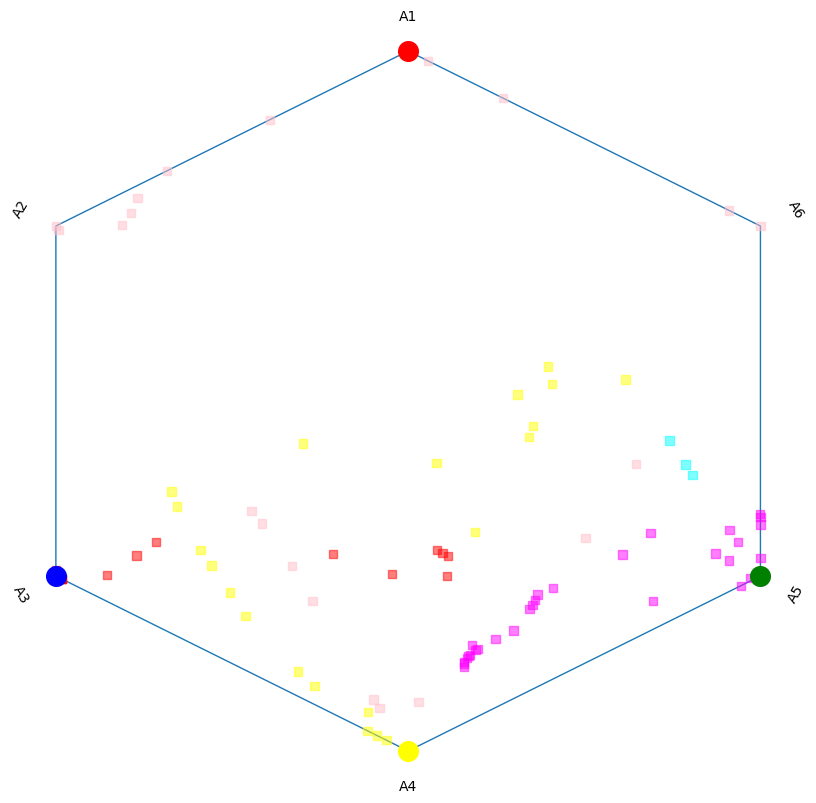

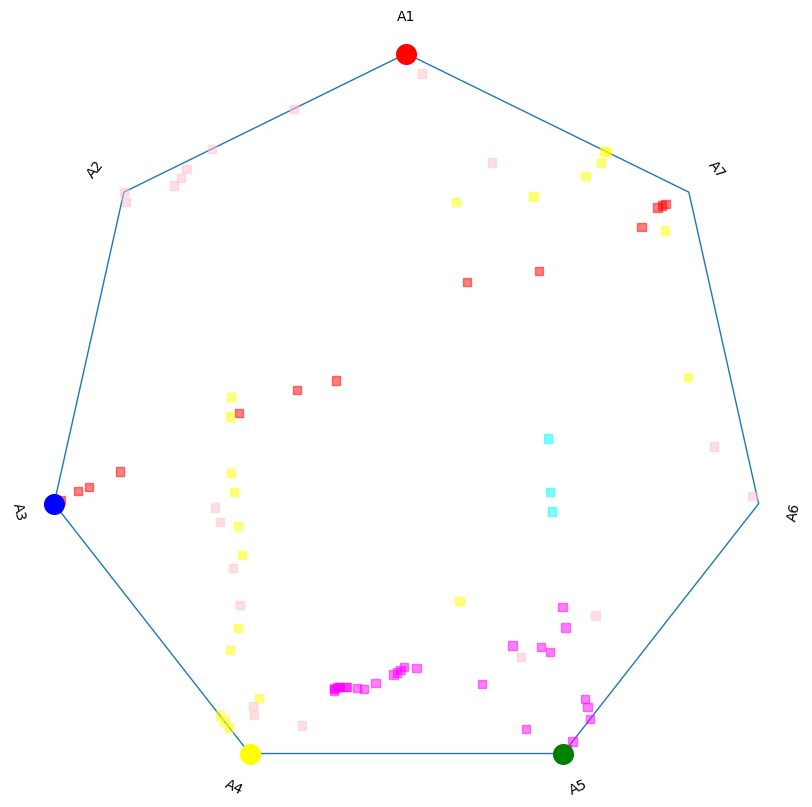

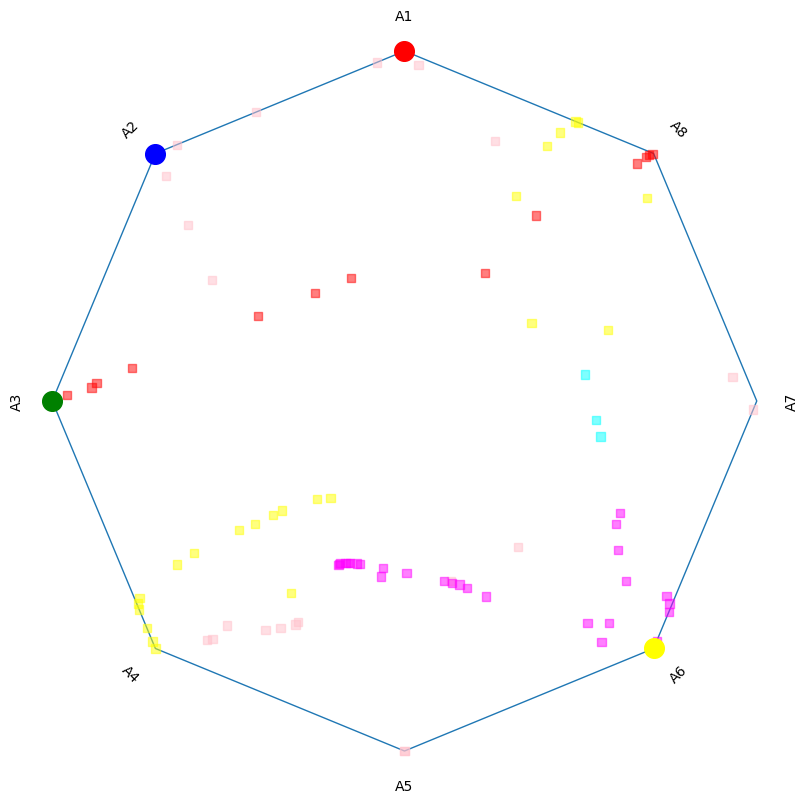

In [123]:
lst_feat = ['C'+str(i) for i in range(1,len(L1_LA_data.columns)+1-6)]

sc = StandardScaler()
X = L1_LA_data[lst_feat].values
X_scaled = sc.fit_transform(X)

AA_list=[]
for i in range(3,9):
    AA = ArchetypalAnalysis(n_archetypes = i, 
                            tolerance = 0.001, 
                            max_iter = 200, 
                            random_state = 0, 
                            C = 0.0001, 
                            initialize = 'random',
                            redundancy_try = 30)
    AA.fit(X_scaled)
    AA.plot_simplex(AA.alfa)
    AA_list.append(AA)
    
arr1 = AA_list[1].archetypes.T
color_indices = []
for AA in AA_list[1:]:
    arr2 = AA.archetypes.T
    similarities = cosine_similarity(arr1, arr2)
    sorted_indices = np.argsort(similarities, axis=None)[::-1]
    max_indices = np.unravel_index(sorted_indices, similarities.shape)
    sorted_indices = sorted(zip(max_indices[0][:4], max_indices[1][:4]), key=lambda x: x[0])
    sorted_second_indices = [idx2 for _, idx2 in sorted_indices]
    plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args=plot_args, grid_on=True)

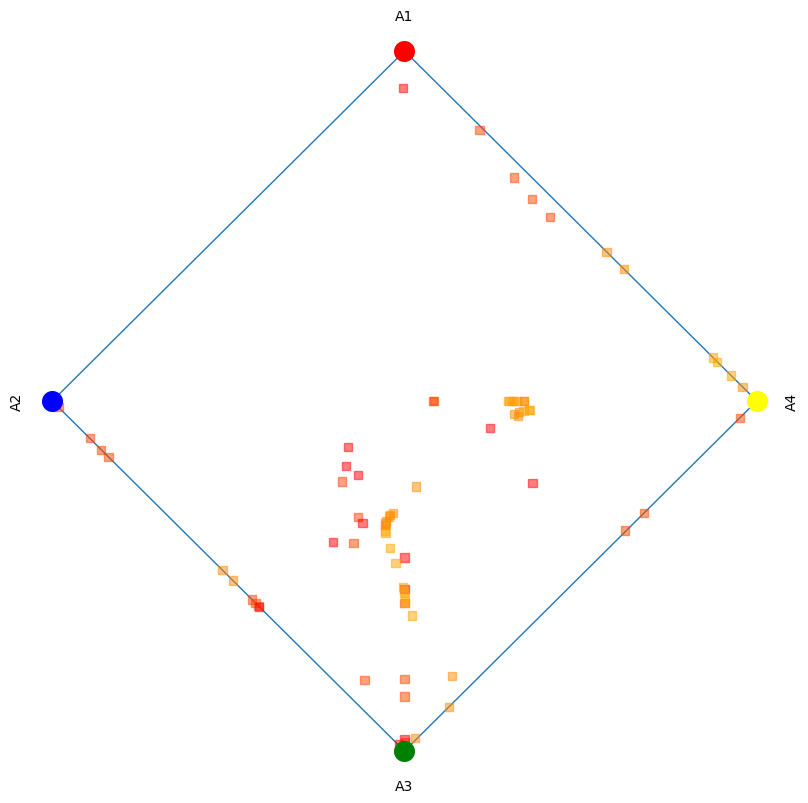

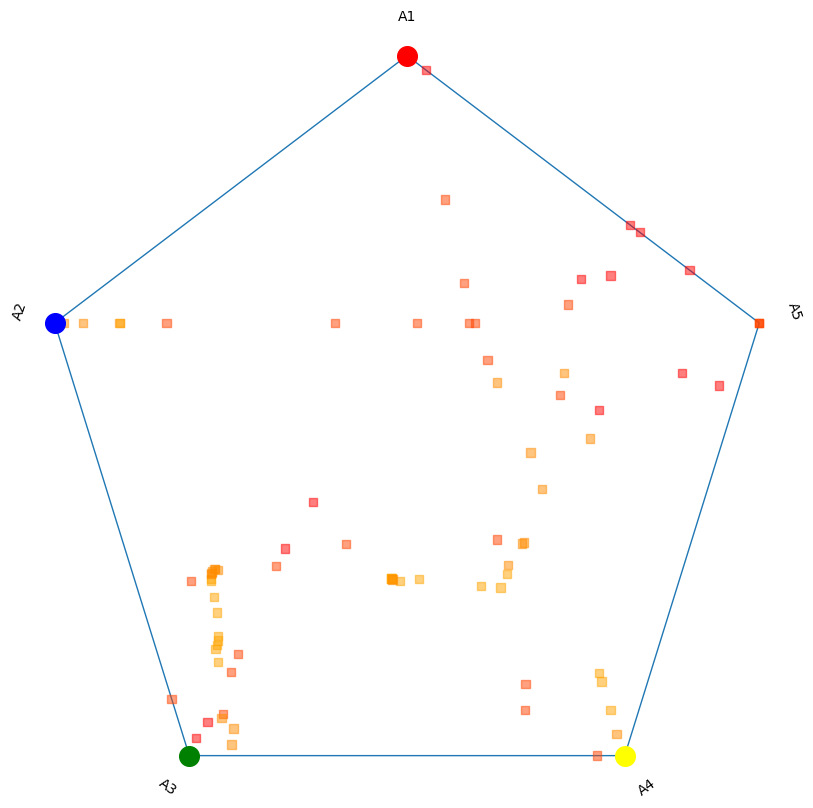

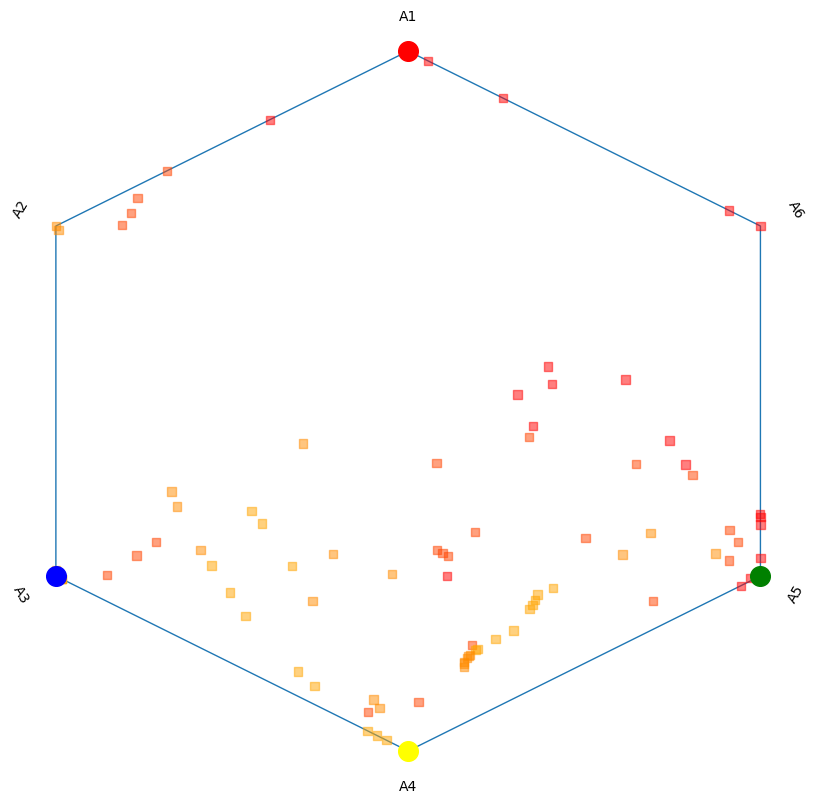

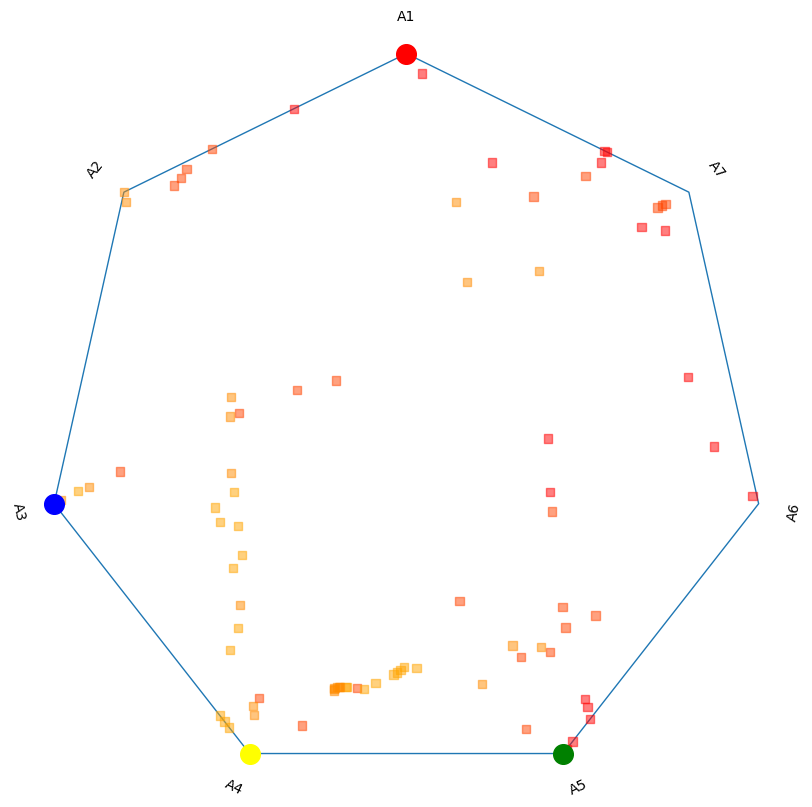

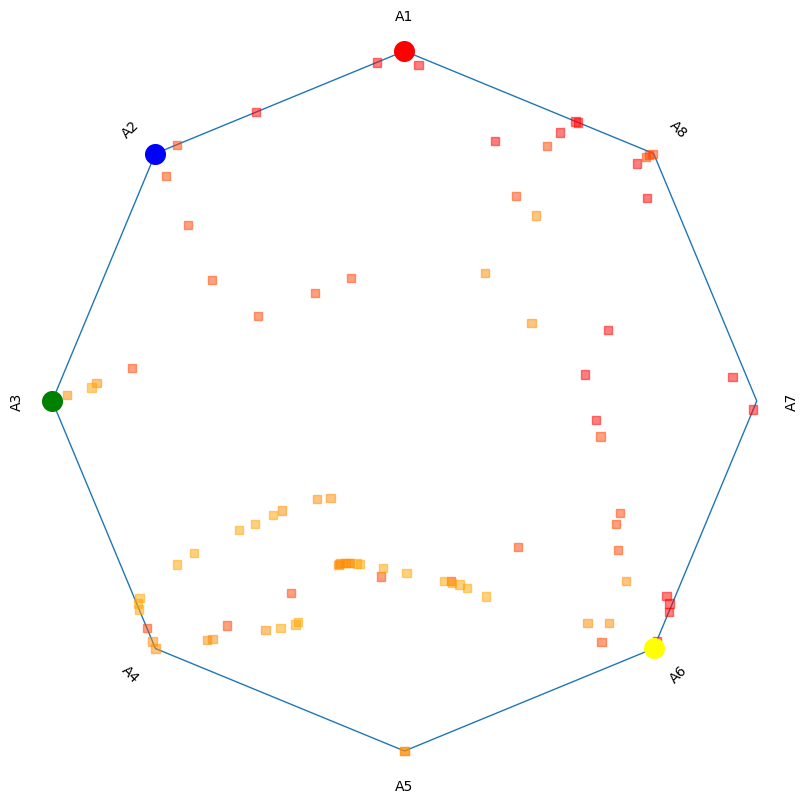

In [148]:
# Discretize cosine of SZA values into categories or bins
num_bins = 4  # Adjust the number of bins as needed
bin_edges = [-1, -0.5, 0, 0.5, 1] #np.linspace(0, 1, num_bins + 1)
categories = np.digitize(L1_LA_data[['cos_sza']], bin_edges) + 1
cossza_color = {1: 'lightyellow', 2: 'orange', 3: 'darkorange', 4: 'orangered', 5: 'red'}

df_args = L1_LA_data[['cos_sza']].copy()
df_args['cos_sza_cat'] = categories

df_args['color'] = df_args['cos_sza_cat'].map(cossza_color)
plot_args = {'color': df_args['color']}

arr1 = AA_list[1].archetypes.T
color_indices = []
for AA in AA_list[1:]:
    arr2 = AA.archetypes.T
    similarities = cosine_similarity(arr1, arr2)
    sorted_indices = np.argsort(similarities, axis=None)[::-1]
    max_indices = np.unravel_index(sorted_indices, similarities.shape)
    sorted_indices = sorted(zip(max_indices[0][:4], max_indices[1][:4]), key=lambda x: x[0])
    sorted_second_indices = [idx2 for _, idx2 in sorted_indices]
    plot_simplex(AA.n_archetypes, AA.alfa, color_vertex= sorted_second_indices, plot_args=plot_args, grid_on=True)

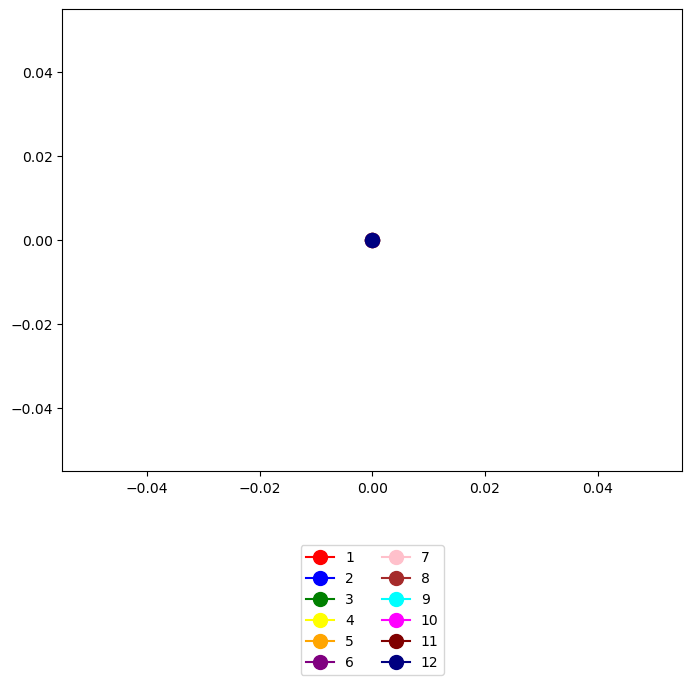

In [144]:
import matplotlib.pyplot as plt

# Assuming region_color is your dictionary

# Data
uniq_locations = list(month_color.keys())

# Plotting
plt.figure(figsize=(8, 6))
for location, color in month_color.items():
    plt.plot(0, 0, marker='o', color=color, markersize=10, label=f'{location}') #' - {color}')

plt.legend(loc='center', bbox_to_anchor=(0.5, -0.3), ncol=2)
plt.show()

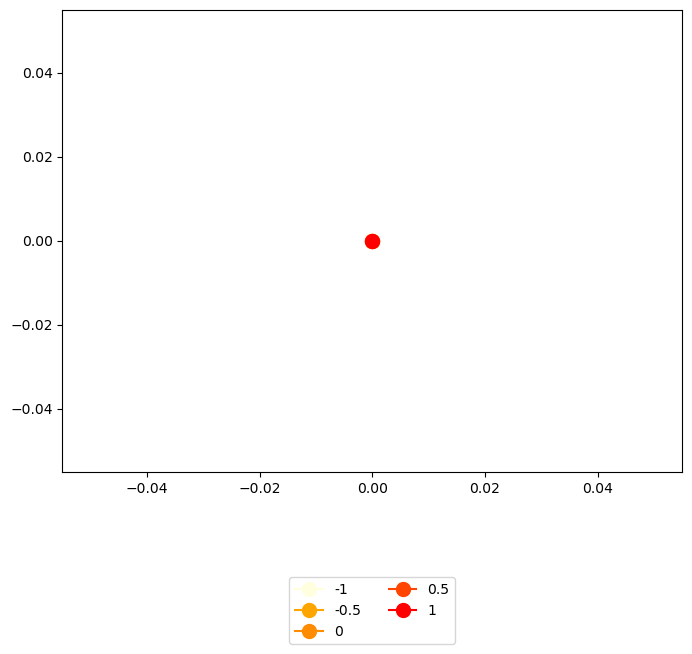

In [149]:


# Assuming region_color is your dictionary

# Data
uniq_locations = list(cossza_color.keys())

# Plotting
plt.figure(figsize=(8, 6))
for location, color in cossza_color.items():
    plt.plot(0, 0, marker='o', color=color, markersize=10, label=f'{bin_edges[location-1]}') #' - {color}')

plt.legend(loc='center', bbox_to_anchor=(0.5, -0.3), ncol=2)
plt.show()